In [ ]:
!pip install talos

In [2]:
import talos
import astetik as ast
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from plotly.graph_objs import *

# Connect to drive



In [3]:
from google.colab import drive
drive.mount('/gdrive')
path = "/gdrive/My Drive/ProteinsML/Protein-subcellular-localization/random_search_results"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).




> # FFN



Search parameters:
```
'batch_size': (32, 256, 32),
'lr': [0.0001, 0.0005, 0.001, 0.0015, 0.0020, 0.0025, 0.0030, 0.0035, 0.004, 0.005, 0.007],
'n_hid': (5, 100, 5),
'drop_prob': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
```







> ## Code







```
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential

import numpy as np
import talos
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"


config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
_ = tf.compat.v1.Session(config=config)

# Load the encoded protein sequences, labels and masks
# The masks are not needed for the FFN or CNN models
train = np.load('./data/reduced_train.npz')
X_train = train['X_train']
y_train = train['y_train']
mask_train = train['mask_train']
#print(X_train.shape)
#print(X_train)

validation = np.load('./data/reduced_val.npz')
X_val = validation['X_val']
y_val = validation['y_val']
mask_val = validation['mask_val']

p = {
	'batch_size': (32, 256, 32),
	'lr': [0.0001, 0.0005, 0.001, 0.0015, 0.0020, 0.0025, 0.0030, 0.0035, 0.004, 0.005, 0.007],
	#'n_filt': (5, 50, 5),
	'n_hid': (5, 100, 5),
	'drop_prob': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
}

experiment_name = "random_search/FNN"

def create_FNN(X_train, y_train, X_val, y_val, params):
	# Set hyperparameters
	seq_len = 400
	n_feat = 20
	n_class = 10
	num_epochs = 120

	"""
	Building the network by defining its architecture: input layer, dense layer, output layer
	:param hp: optional hyerparameter container. A HyperParameters instance contains information about both the
				search space and the current values of each hyperparameter.
	"""

	# Define the layers of the network
	input_shape = (seq_len, n_feat)
	model = Sequential()
	# Input layer, holds the shape of the data, flattening the input
	model.add(layers.Flatten(input_shape=input_shape))
	# Dense layer with ReLu activation function
	model.add(layers.Dense(units=params['n_hid'], activation='relu'))
	model.add(layers.Dropout(params['drop_prob']))
	# Output layer with a Softmax activation function
	model.add(layers.Dense(units=n_class, activation='softmax'))

	# Calculate the prediction and network loss for the training set and update the network weights:
	model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=params['lr']),
					   metrics=['accuracy'])
	history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=params['batch_size'],
						validation_data=(X_val, y_val), shuffle=True)

	return history, model


n_class = 10
y_train = to_categorical(y_train, n_class)
y_val = to_categorical(y_val, n_class)

t = talos.Scan(x=X_train, y=y_train, x_val=X_val, y_val=y_val, params=p, fraction_limit=0.01, model=create_FNN, performance_target='val_loss', experiment_name=experiment_name, disable_progress_bar=False, print_params=True)

```





> ## Results (Paper dataset)



In [4]:
ffn_data = talos.Analyze(path + "/paper-dataset/FNN/052521102043.csv")
# access the dataframe with the results
ffn_data.data.head()

,round_epochs,loss,acc,val_loss,val_acc,batch_size,drop_prob,lr,n_hid
0,120,0.000350,1.000000,1.246131,0.759055,88,0.2,0.0015,81
1,120,0.021327,0.994635,1.281403,0.762205,172,0.6,0.0020,62
2,120,0.020983,0.990920,2.315510,0.771654,60,0.5,0.0035,81
3,120,0.072092,0.969459,1.538661,0.752756,130,0.6,0.0020,43
4,120,0.003569,0.999587,1.418240,0.751181,249,0.1,0.0050,24


In [5]:
# Minimum val_loss
ffn_data.data.nsmallest(5, 'val_loss')

,round_epochs,loss,acc,val_loss,val_acc,batch_size,drop_prob,lr,n_hid
50,120,0.177328,0.964507,0.771780,0.762205,67,0.7,0.0001,62
122,120,0.090148,0.986380,0.780074,0.757480,67,0.2,0.0001,24
92,120,0.172198,0.982253,0.796330,0.757480,207,0.6,0.0001,81
101,120,0.264442,0.958729,0.812574,0.754331,130,0.7,0.0001,62
81,120,0.255342,0.965332,0.821229,0.741732,165,0.2,0.0001,24


In [6]:
# Maximum val_accuracy
ffn_data.data.nlargest(5, 'val_acc')

,round_epochs,loss,acc,val_loss,val_acc,batch_size,drop_prob,lr,n_hid
74,120,0.001214,1.000000,0.954583,0.776378,95,0.2,0.0005,81
97,120,0.002389,0.999175,1.245346,0.776378,53,0.3,0.0010,62
8,120,0.001029,1.000000,1.249108,0.773228,228,0.1,0.0050,43
39,120,0.004407,0.998762,1.264371,0.773228,193,0.5,0.0020,81
65,120,0.200786,0.911267,1.309725,0.773228,214,0.7,0.0025,43


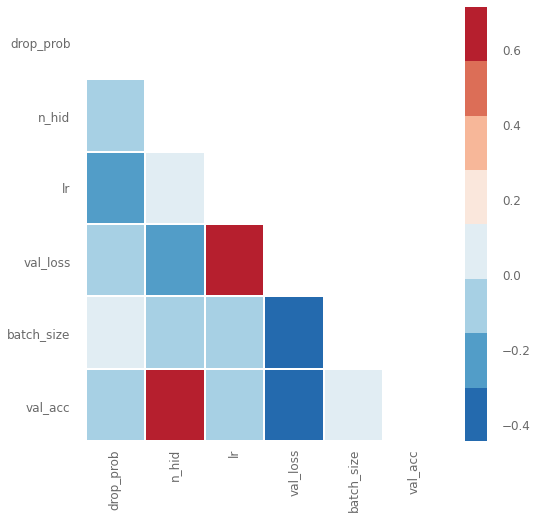

In [7]:
ffn_data.plot_corr('val_loss', ['acc', 'loss', 'round_epochs', 'duration'])

In [8]:
#ast.kde(ffn_data.data, 'n_hid','val_loss', title="FNN", x_label="n_hid", y_label="val_loss")
#ast.kde(ffn_data.data, 'lr','val_loss', title="FNN", x_label="lr", y_label="val_loss")
#ast.kde(ffn_data.data, 'batch_size','val_loss', title="FNN", x_label="batch_size", y_label="val_loss")

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


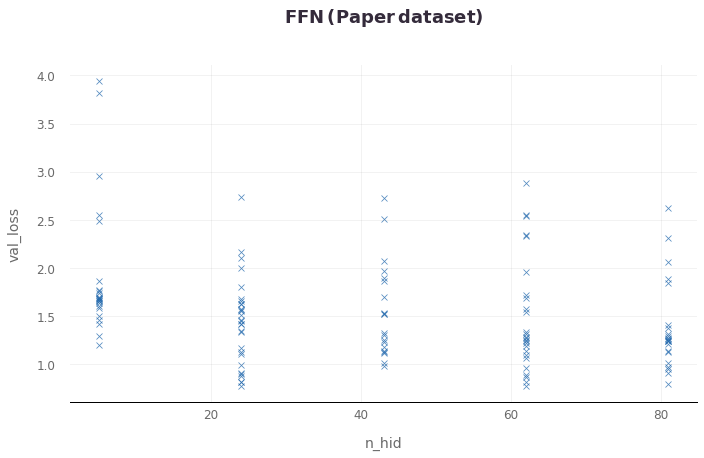

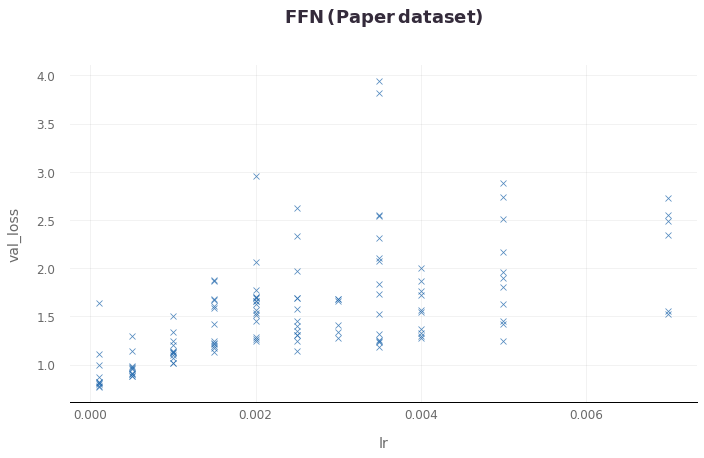

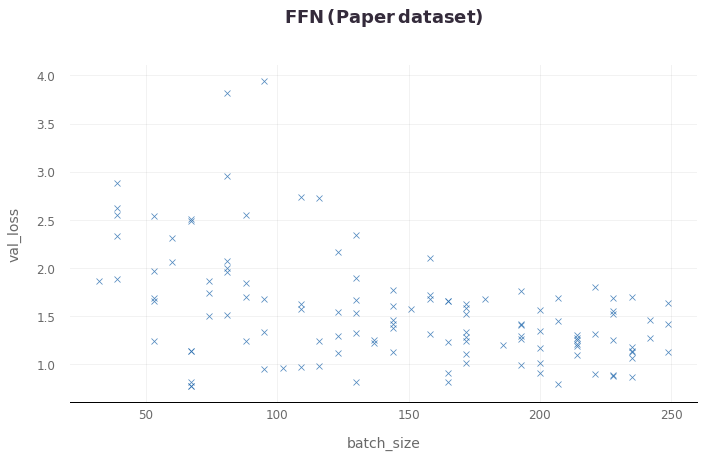

In [9]:
# a regression plot for two dimensions 
ast.regs(ffn_data.data, 'n_hid', 'val_loss', title="FFN (Paper dataset)", x_label="n_hid", y_label="val_loss")
ast.regs(ffn_data.data, 'lr', 'val_loss', title="FFN (Paper dataset)", x_label="lr", y_label="val_loss")
ast.regs(ffn_data.data, 'batch_size', 'val_loss', title="FFN (Paper dataset)", x_label="batch_size", y_label="val_loss")

> ## Results (Our one-hot dataset)

In [10]:
ffn_oh = talos.Analyze(path + "/our-one-hot/FFN_oh/061621105801.csv")
# access the dataframe with the results
ffn_oh_data = ffn_oh.data.drop(['loss', 'subcellular_loss', 'membrane_loss', 'subcellular_acc', 'membrane_acc'], axis=1)

In [11]:
# Minimum val_loss
ffn_oh_data.nsmallest(5, 'val_subcellular_loss')

,round_epochs,val_loss,val_subcellular_loss,val_membrane_loss,val_subcellular_acc,val_membrane_acc,batch_size,drop_prob,lr,n_hid
341,120,2.574835,1.480115,0.812070,0.436508,0.558201,151,0.6,0.0001,24
133,120,2.566272,1.480879,1.034727,0.477513,0.574074,242,0.6,0.0001,81
165,120,2.580725,1.498198,0.937654,0.456349,0.571429,249,0.2,0.0001,24
423,120,2.589048,1.555527,1.011064,0.486772,0.570106,214,0.5,0.0001,43
416,120,2.535653,1.563817,0.948361,0.448413,0.566138,214,0.7,0.0001,62


In [12]:
# Maximum val_accuracy
ffn_oh_data.nlargest(5, 'val_subcellular_acc')

,round_epochs,val_loss,val_subcellular_loss,val_membrane_loss,val_subcellular_acc,val_membrane_acc,batch_size,drop_prob,lr,n_hid
295,120,5.576973,3.786062,2.601040,0.493386,0.554233,249,0.5,0.0020,81
437,120,3.391968,2.028847,1.420958,0.490741,0.579365,39,0.7,0.0001,62
38,120,6.846393,4.114229,2.865820,0.489418,0.575397,228,0.5,0.0040,81
65,120,5.080647,2.476385,2.391365,0.489418,0.550265,235,0.1,0.0025,81
120,120,4.746563,2.868828,1.992371,0.488095,0.576720,144,0.7,0.0015,43




> ## Results (Our psi-blast dataset)



In [13]:
ffn_psi = talos.Analyze(path + "/our-psi-blast/FFN_psi/060621143655.csv")
# access the dataframe with the results
ffn_psi_data = ffn_psi.data.drop(['loss', 'subcellular_loss', 'membrane_loss', 'subcellular_acc', 'membrane_acc', 'n_filt'], axis=1)

In [14]:
# Minimum val_loss
ffn_psi_data.nsmallest(5, 'val_subcellular_loss')

,round_epochs,val_loss,val_subcellular_loss,val_membrane_loss,val_subcellular_acc,val_membrane_acc,batch_size,drop_hid,drop_prob,lr,n_hid
97,120,2.009963,1.360240,0.609511,0.562750,0.737810,242,0.7,0.5,0.0001,81
358,120,1.949319,1.367831,0.569488,0.559552,0.749001,151,0.3,0.7,0.0001,62
324,120,1.960778,1.374945,0.567713,0.553957,0.742606,221,0.5,0.3,0.0001,24
355,120,2.009332,1.388783,0.627852,0.553957,0.731415,221,0.2,0.3,0.0001,43
207,120,2.064885,1.393660,0.668045,0.563549,0.732214,214,0.5,0.2,0.0001,43


In [15]:
# Maximum val_accuracy
ffn_psi_data.nlargest(5, 'val_subcellular_acc')

,round_epochs,val_loss,val_subcellular_loss,val_membrane_loss,val_subcellular_acc,val_membrane_acc,batch_size,drop_hid,drop_prob,lr,n_hid
429,120,2.095018,1.404026,0.672159,0.566747,0.744205,242,0.7,0.2,0.0001,62
419,120,3.845785,2.364074,1.385542,0.565947,0.724221,228,0.4,0.2,0.0010,62
207,120,2.064885,1.393660,0.668045,0.563549,0.732214,214,0.5,0.2,0.0001,43
97,120,2.009963,1.360240,0.609511,0.562750,0.737810,242,0.7,0.5,0.0001,81
268,120,4.744222,3.276267,1.489028,0.562750,0.729017,249,0.1,0.6,0.0030,43




> # CNN



Search parameters:


```
'batch_size': (32, 256, 32),
'lr': [0.0001, 0.0005, 0.001, 0.0015, 0.0020, 0.0025, 0.0030, 0.0035, 0.004, 0.005, 0.007],
'n_filt': (5, 50, 5),
'n_hid': (5, 100, 5),
'drop_prob': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
```





> ## Code





```
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

import numpy as np
import talos
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"


config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
_ = tf.compat.v1.Session(config=config)

# Load the encoded protein sequences, labels and masks
# The masks are not needed for the FFN or CNN models
train = np.load('./data/reduced_train.npz')
X_train = train['X_train']
y_train = train['y_train']
mask_train = train['mask_train']
#print(X_train.shape)
#print(X_train)

validation = np.load('./data/reduced_val.npz')
X_val = validation['X_val']
y_val = validation['y_val']
mask_val = validation['mask_val']

p = {
	'batch_size': (32, 256, 32),
	'lr': [0.0001, 0.0005, 0.001, 0.0015, 0.0020, 0.0025, 0.0030, 0.0035, 0.004, 0.005, 0.007],
	'n_filt': (5, 50, 5),
	'n_hid': (5, 100, 5),
	'drop_prob': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
}

experiment_name = "random_search/CNN"

def create_CNN(X_train, y_train, X_val, y_val, params):
	# Set hyperparameters

	seq_len = 400
	n_feat = 20
	n_class = 10
	num_epochs = 120

	"""
	Building the network by defining its architecture: input layer, two convolutional layers with max pooling,
														a dense layer and an output layer.
	:param hp: optional hyerparameter container. A HyperParameters instance contains information about both the
			search space and the current values of each hyperparameter.
	"""

	# Build model
	inputs = keras.Input(shape=(seq_len, n_feat))
	l_permute = layers.Permute((2, 1))(inputs)

	l_conv_a = layers.Conv1D(params['n_filt'], 3, strides=1, padding="same", activation="relu", data_format='channels_first') \
		(l_permute)
	l_conv_b = layers.Conv1D(params['n_filt'], 5, strides=1, padding="same", activation="relu", data_format='channels_first') \
		(l_permute)
	l_conc = tf.keras.layers.Concatenate(axis=1)([l_conv_a, l_conv_b])

	l_conv_final = layers.Conv1D(params['n_filt'] * 2, 3, strides=1, padding="same", activation="relu",
								 data_format='channels_first')(l_conc)
	l_reshu = layers.Permute((2, 1))(l_conv_final)

	final_max_pool = layers.MaxPooling1D(5)(l_reshu)
	final_max_pool = layers.Flatten()(final_max_pool)

	l_dense = layers.Dense(params['n_hid'], activation="relu")(final_max_pool)
	l_dense = layers.Dropout(params['drop_prob'])(l_dense)
	l_out = layers.Dense(n_class, activation="softmax")(l_dense)

	model = keras.Model(inputs, l_out)
	model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=params['lr']),
					   metrics=['accuracy'])
	history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=params['batch_size'],
						validation_data=(X_val, y_val), shuffle=True)

	return history, model


n_class = 10
y_train = to_categorical(y_train, n_class)
y_val = to_categorical(y_val, n_class)

t = talos.Scan(x=X_train, y=y_train, x_val=X_val, y_val=y_val, params=p, fraction_limit=0.005, model=create_CNN, performance_target='val_loss', experiment_name=experiment_name, disable_progress_bar=False, print_params=True)


```





> ## Results (Paper Dataset)



In [16]:
cnn_data = talos.Analyze(path + "/paper-dataset/CNN/052521115743.csv")
# access the dataframe with the results
cnn_data.data.head()

,round_epochs,loss,acc,val_loss,val_acc,batch_size,drop_prob,lr,n_filt,n_hid
0,120,0.011052,0.996286,1.480641,0.833071,123,0.2,0.0020,23,62
1,120,1.626517,0.453570,1.626610,0.469291,242,0.2,0.0001,5,24
2,120,0.088076,0.968221,1.422120,0.773228,186,0.1,0.0025,5,24
3,120,0.876525,0.678085,1.267855,0.688189,95,0.2,0.0025,5,5
4,120,0.005946,0.998349,1.847723,0.773228,130,0.1,0.0035,5,81


In [17]:
# Minimum val_loss
cnn_data.data.nsmallest(5, 'val_loss')

,round_epochs,loss,acc,val_loss,val_acc,batch_size,drop_prob,lr,n_filt,n_hid
157,120,0.296938,0.915394,0.628220,0.806299,207,0.3,0.0001,32,62
65,120,0.509409,0.832439,0.655842,0.784252,172,0.5,0.0001,41,43
97,120,0.232365,0.938919,0.656866,0.807874,207,0.2,0.0001,23,81
27,120,0.084010,0.986793,0.672911,0.815748,130,0.2,0.0001,41,81
131,120,0.449372,0.864631,0.674720,0.785827,249,0.6,0.0001,41,81


In [18]:
# Maximum val_accuracy
cnn_data.data.nlargest(5, 'val_acc')

,round_epochs,loss,acc,val_loss,val_acc,batch_size,drop_prob,lr,n_filt,n_hid
194,120,0.090801,0.966983,1.478755,0.862992,74,0.7,0.0035,23,81
125,120,0.077359,0.966983,1.501488,0.856693,179,0.6,0.0040,32,62
37,120,0.168640,0.930665,1.439325,0.855118,39,0.7,0.0020,32,62
119,120,0.011130,0.996286,1.467603,0.855118,249,0.3,0.0040,41,62
185,120,0.017475,0.993397,1.419270,0.853543,179,0.4,0.0040,23,62


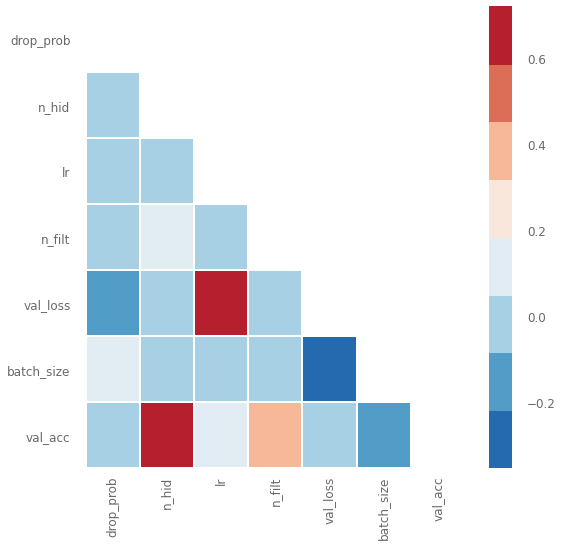

In [19]:
cnn_data.plot_corr('val_loss', ['acc', 'loss', 'round_epochs', 'duration'])

In [20]:
#ast.kde(cnn_data.data, 'n_hid','val_acc', title="FNN", x_label="n_hid", y_label="val_accuracy")
#ast.kde(cnn_data.data, 'lr','val_loss', title="FNN", x_label="lr", y_label="val_loss")
#ast.kde(cnn_data.data, 'batch_size','val_loss', title="FNN", x_label="batch_size", y_label="val_loss")

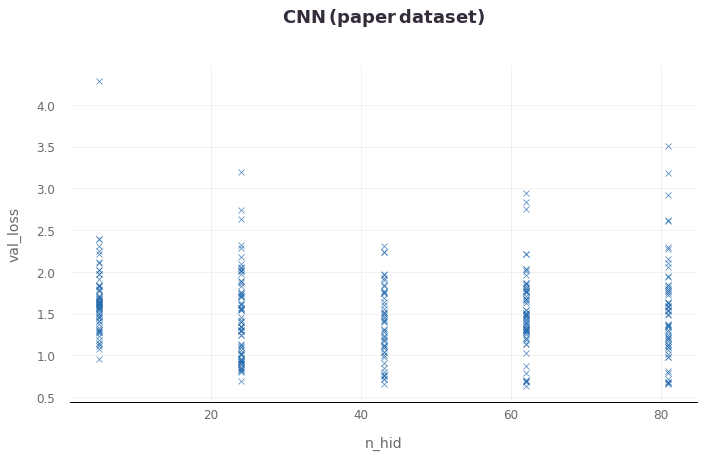

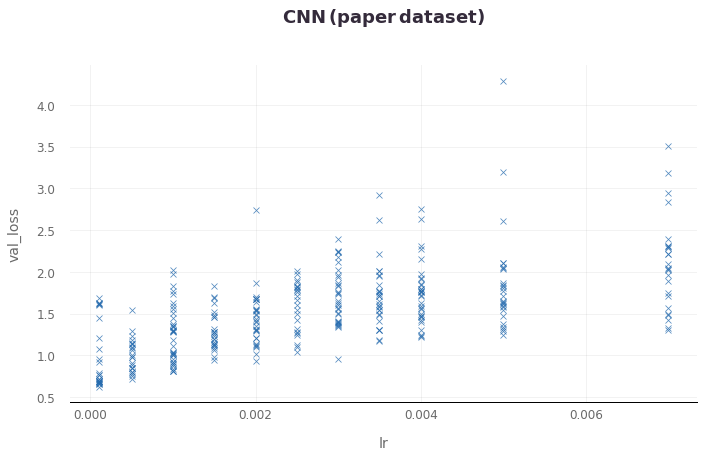

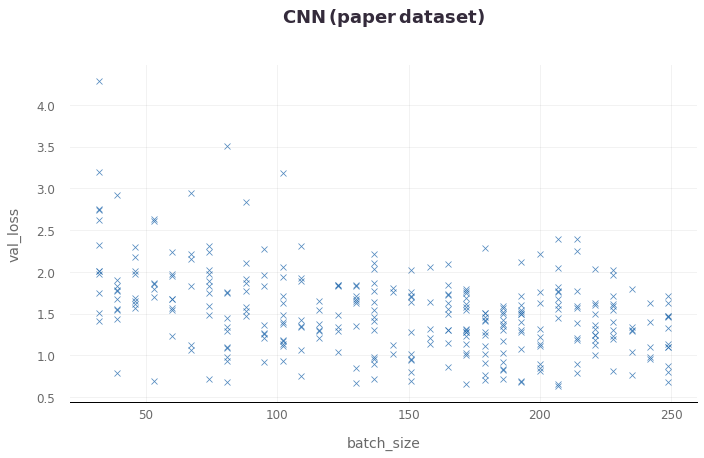

In [21]:
# a regression plot for two dimensions 
ast.regs(cnn_data.data, 'n_hid', 'val_loss', title="CNN (paper dataset)", x_label="n_hid", y_label="val_loss")
ast.regs(cnn_data.data, 'lr', 'val_loss', title="CNN (paper dataset)", x_label="lr", y_label="val_loss")
ast.regs(cnn_data.data, 'batch_size', 'val_loss', title="CNN (paper dataset)", x_label="batch_size", y_label="val_loss")



> ## Results (Our one-hot dataset)



In [22]:
cnn_oh = talos.Analyze(path + "/our-one-hot/CNN_oh/060121125517.csv")
# access the dataframe with the results
cnn_oh_data = cnn_oh.data.drop(['loss', 'subcellular_loss', 'membrane_loss', 'subcellular_acc', 'membrane_acc'], axis=1)

In [23]:
# Minimum val_loss
cnn_oh_data.nsmallest(5, 'val_subcellular_loss')

,round_epochs,val_loss,val_subcellular_loss,val_membrane_loss,val_subcellular_acc,val_membrane_acc,batch_size,drop_prob,lr,n_filt,n_hid
262,120,2.560978,1.411093,0.834484,0.453083,0.548257,186,0.4,0.0005,5,43
242,120,2.445304,1.462899,0.984124,0.505362,0.587131,158,0.1,0.0001,32,24
266,120,2.422623,1.478749,0.931319,0.498660,0.572386,214,0.1,0.0001,14,24
276,120,2.398064,1.490543,0.932656,0.509383,0.565684,179,0.6,0.0001,23,62
55,120,2.374220,1.495511,0.922137,0.500000,0.584450,207,0.2,0.0001,41,24


In [24]:
# Maximum val_accuracy
cnn_oh_data.nlargest(5, 'val_subcellular_acc')

,round_epochs,val_loss,val_subcellular_loss,val_membrane_loss,val_subcellular_acc,val_membrane_acc,batch_size,drop_prob,lr,n_filt,n_hid
96,120,7.629267,4.894945,2.923975,0.514745,0.601877,221,0.5,0.0035,32,81
276,120,2.398064,1.490543,0.932656,0.509383,0.565684,179,0.6,0.0001,23,62
172,120,3.300716,1.717581,1.376008,0.506702,0.565684,74,0.2,0.0001,32,81
240,120,2.869144,1.642189,1.250057,0.505362,0.585791,67,0.3,0.0001,41,24
242,120,2.445304,1.462899,0.984124,0.505362,0.587131,158,0.1,0.0001,32,24




> ## Results (Our psi-Blast dataset)



In [25]:
cnn_psi = talos.Analyze(path + "/our-psi-blast/CNN_psi/060721091423.csv")
# access the dataframe with the results
cnn_psi_data = cnn_psi.data.drop(['loss', 'subcellular_loss', 'membrane_loss', 'subcellular_acc', 'membrane_acc','drop_hid'], axis=1)

In [26]:
# Minimum val_loss
cnn_psi_data.nsmallest(5, 'val_subcellular_loss')

,round_epochs,val_loss,val_subcellular_loss,val_membrane_loss,val_subcellular_acc,val_membrane_acc,batch_size,drop_prob,lr,n_filt,n_hid
259,120,1.711429,1.191633,0.435018,0.605116,0.794564,207,0.4,0.0001,32,43
207,120,1.670115,1.191908,0.462052,0.633094,0.793765,88,0.5,0.0001,23,62
4,120,1.677556,1.193681,0.466394,0.638689,0.796962,95,0.5,0.0001,41,62
334,120,1.661688,1.209447,0.450978,0.618705,0.791367,214,0.2,0.0001,23,62
292,120,1.705879,1.221180,0.491634,0.639488,0.801759,67,0.6,0.0001,41,62


In [27]:
# Maximum val_accuracy
cnn_psi_data.nlargest(5, 'val_subcellular_acc')

,round_epochs,val_loss,val_subcellular_loss,val_membrane_loss,val_subcellular_acc,val_membrane_acc,batch_size,drop_prob,lr,n_filt,n_hid
345,120,1.864651,1.307712,0.545148,0.642686,0.793765,46,0.6,0.0001,32,62
292,120,1.705879,1.221180,0.491634,0.639488,0.801759,67,0.6,0.0001,41,62
317,120,5.102492,3.840089,1.269330,0.639488,0.803357,74,0.6,0.0015,32,81
4,120,1.677556,1.193681,0.466394,0.638689,0.796962,95,0.5,0.0001,41,62
205,120,4.949611,3.264737,1.676788,0.638689,0.793765,60,0.4,0.0005,41,81




> # BLSTM




Search parameters:


```
'batch_size': (32, 256, 32),
'lr': [0.0001, 0.0005, 0.001, 0.0015, 0.0020, 0.0025, 0.0030, 0.0035, 0.004, 0.005, 0.007],
'n_filt': (5, 50, 5),
'n_hid': (5, 100, 5),
'drop_prob': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
```





> ## Code





```
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

import numpy as np
import talos
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"


config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
_ = tf.compat.v1.Session(config=config)

# Load the encoded protein sequences, labels and masks
# The masks are not needed for the FFN or CNN models
train = np.load('./data/reduced_train.npz')
X_train = train['X_train']
y_train = train['y_train']
mask_train = train['mask_train']
#print(X_train.shape)
#print(X_train)

validation = np.load('./data/reduced_val.npz')
X_val = validation['X_val']
y_val = validation['y_val']
mask_val = validation['mask_val']

p = {
	'batch_size': (32, 256, 32),
	'lr': [0.0001, 0.0005, 0.001, 0.0015, 0.0020, 0.0025, 0.0030, 0.0035, 0.004, 0.005, 0.007],
	#'n_filt': (5, 50, 5),
	'n_hid': (5, 100, 5),
	'drop_prob': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
}

experiment_name = "random_search/LSTM"

def create_LSTM(X_train, y_train, X_val, y_val, params):
	# Set hyperparameters

	seq_len = 400
	n_feat = 20
	n_class = 10
	num_epochs = 120

	"""
	Building the network by defining its architecture: input layer, a bidirectional LSTM, a dense layer and an
														output layer
	:param hp: optional hyerparameter container. A HyperParameters instance contains information about both the
			search space and the current values of each hyperparameter.
	"""
	# Build model defining the layers
	# Define input
	l_input = keras.Input(shape=(seq_len, n_feat))

	# mask to ignore the padded positions
	l_mask = layers.Masking(mask_value=0.0)(l_input)

	# Bidirectional LSTM layer, taking only the last hidden state (only_return_final)
	l_fwd = layers.LSTM(units=params['n_hid'], activation="tanh", return_sequences=False)(l_mask)
	l_bwd = layers.LSTM(units=params['n_hid'], activation="tanh", return_sequences=False, go_backwards=True)(l_mask)

	# Concatenate both layers
	l_conc_lstm = tf.keras.layers.Concatenate(axis=1)([l_fwd, l_bwd])

	# Dense layer with ReLu activation function
	l_dense = layers.Dense(params['n_hid'] * 2, activation="relu")(l_conc_lstm)

	# Output layer with a Softmax activation function. Note that we include a dropout layer
	l_dropout = layers.Dropout(params['drop_prob'])(l_dense)
	l_out = layers.Dense(n_class, activation="softmax")(l_dropout)

	model = keras.Model(l_input, l_out)
	model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=params['lr']),
					   metrics=['accuracy'])
	history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=params['batch_size'],
						validation_data=(X_val, y_val), shuffle=True)

	return history, model


n_class = 10
y_train = to_categorical(y_train, n_class)
y_val = to_categorical(y_val, n_class)

t = talos.Scan(x=X_train, y=y_train, x_val=X_val, y_val=y_val, params=p, fraction_limit=0.005, model=create_LSTM, performance_target='val_loss', experiment_name=experiment_name, disable_progress_bar=False, print_params=True)

```





> ## Results (Paper dataset)



In [28]:
lstm_data = talos.Analyze(path + "/paper-dataset/LSTM/052521141425.csv")
# access the dataframe with the results
lstm_data.data.head()

,round_epochs,loss,acc,val_loss,val_acc,batch_size,drop_prob,lr,n_hid
0,120,0.127723,0.954189,0.732136,0.848819,32,0.2,0.0020,24
1,120,1.241082,0.523318,1.174048,0.598425,235,0.6,0.0040,5
2,120,0.081812,0.973999,0.866894,0.853543,228,0.2,0.0035,43
3,120,0.003194,0.999175,1.138813,0.855118,123,0.1,0.0035,81
4,120,0.537440,0.820470,0.766625,0.777953,193,0.6,0.0025,24


In [29]:
# Minimum val_loss
lstm_data.data.nsmallest(5, 'val_loss')

,round_epochs,loss,acc,val_loss,val_acc,batch_size,drop_prob,lr,n_hid
9,120,0.505500,0.839042,0.568436,0.814173,144,0.4,0.0005,62
6,120,0.638452,0.782088,0.653599,0.781102,200,0.7,0.0025,24
15,120,0.592410,0.800660,0.689809,0.760630,165,0.3,0.0005,24
7,120,0.551980,0.803962,0.727522,0.796850,242,0.6,0.0070,24
0,120,0.127723,0.954189,0.732136,0.848819,32,0.2,0.0020,24


In [30]:
# Maximum val_accuracy
lstm_data.data.nlargest(5, 'val_acc')

,round_epochs,loss,acc,val_loss,val_acc,batch_size,drop_prob,lr,n_hid
16,120,0.025889,0.990095,1.267189,0.864567,151,0.7,0.0070,81
8,120,0.011734,0.995873,1.223572,0.859843,46,0.2,0.0050,43
3,120,0.003194,0.999175,1.138813,0.855118,123,0.1,0.0035,81
19,120,0.033975,0.988444,1.161572,0.855118,53,0.6,0.0040,81
2,120,0.081812,0.973999,0.866894,0.853543,228,0.2,0.0035,43


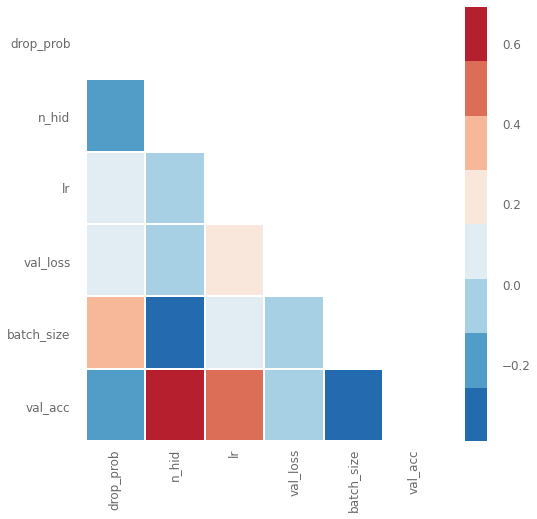

In [31]:
lstm_data.plot_corr('val_loss', ['acc', 'loss', 'round_epochs', 'duration'])

In [32]:
#ast.kde(lstm_data.data, 'n_hid','val_acc', title="BLSTM", x_label="n_hid", y_label="val_accuracy")
#ast.kde(lstm_data.data, 'lr','val_loss', title="BLSTM", x_label="lr", y_label="val_loss")
#ast.kde(lstm_data.data, 'batch_size','val_loss', title="BLSTM", x_label="batch_size", y_label="val_loss")

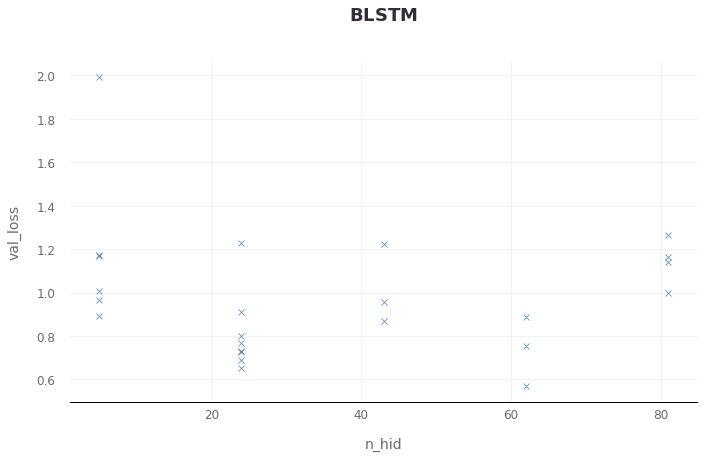

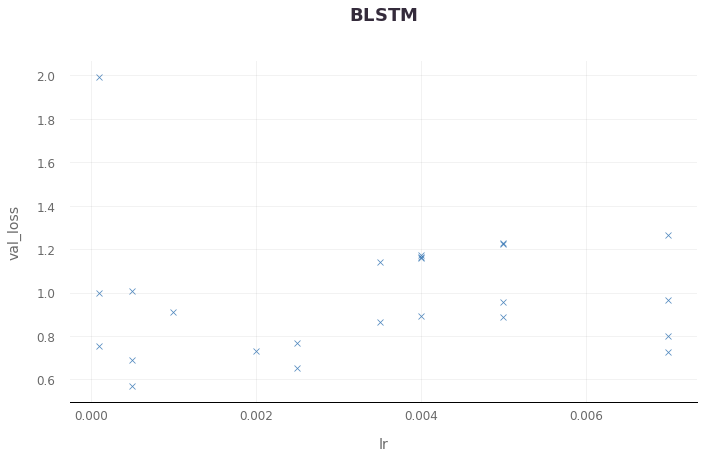

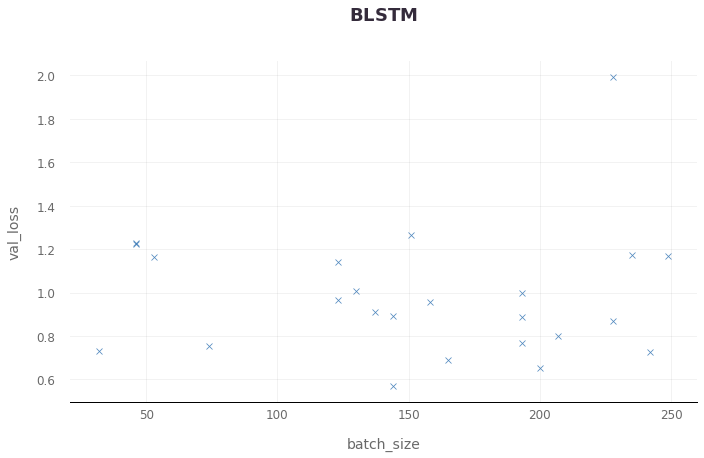

In [33]:
# a regression plot for two dimensions 
ast.regs(lstm_data.data, 'n_hid', 'val_loss', title="BLSTM", x_label="n_hid", y_label="val_loss")
ast.regs(lstm_data.data, 'lr', 'val_loss', title="BLSTM", x_label="lr", y_label="val_loss")
ast.regs(lstm_data.data, 'batch_size', 'val_loss', title="BLSTM", x_label="batch_size", y_label="val_loss")



> ## Results (Our one-hot dataset)



In [34]:
lstm_oh = talos.Analyze(path + "/our-one-hot/LSTM_oh/061621185155.csv")
# access the dataframe with the results
lstm_oh_data = lstm_oh.data.drop(['loss', 'subcellular_loss', 'membrane_loss', 'subcellular_acc', 'membrane_acc'], axis=1)

In [35]:
# Minimum val_loss
lstm_oh_data.nsmallest(5, 'val_subcellular_loss')

,round_epochs,val_loss,val_subcellular_loss,val_membrane_loss,val_subcellular_acc,val_membrane_acc,batch_size,drop_prob,lr,n_hid
35,120,1.960241,1.219407,0.704934,0.541005,0.693122,242,0.3,0.0005,62
33,120,1.939286,1.234565,0.597572,0.541005,0.689153,151,0.6,0.0020,24
37,120,1.940433,1.242799,0.709582,0.556878,0.690476,235,0.7,0.0015,24
24,120,1.971477,1.263337,0.736971,0.560847,0.690476,228,0.1,0.0015,24
31,120,2.068205,1.299050,0.732797,0.534392,0.697090,144,0.1,0.0035,5


In [36]:
# Maximum val_accuracy
lstm_oh_data.nlargest(5, 'val_subcellular_acc')

,round_epochs,val_loss,val_subcellular_loss,val_membrane_loss,val_subcellular_acc,val_membrane_acc,batch_size,drop_prob,lr,n_hid
15,120,2.588101,1.536391,1.054100,0.567460,0.646825,214,0.5,0.0010,81
0,120,2.582869,1.617528,1.096603,0.562169,0.664021,123,0.4,0.0020,24
24,120,1.971477,1.263337,0.736971,0.560847,0.690476,228,0.1,0.0015,24
36,120,2.023524,1.301189,0.744067,0.560847,0.679894,221,0.2,0.0020,24
18,120,2.184131,1.366960,0.815251,0.558201,0.653439,193,0.7,0.0010,62




> ## Results (Our psi-blast dataset)



In [37]:
lstm_psi = talos.Analyze(path + "/our-psi-blast/LSTM_psi/060721155353.csv")
# access the dataframe with the results
lstm_psi_data = lstm_psi.data.drop(['loss', 'subcellular_loss', 'membrane_loss', 'subcellular_acc', 'membrane_acc'], axis=1)

In [38]:
# Minimum val_loss
lstm_psi_data.nsmallest(5, 'val_subcellular_loss')

,round_epochs,val_loss,val_subcellular_loss,val_membrane_loss,val_subcellular_acc,val_membrane_acc,batch_size,drop_prob,lr,n_hid
4,120,1.611180,1.152488,0.378243,0.628297,0.839329,179,0.7,0.0010,43
5,120,1.629157,1.238795,0.409160,0.625100,0.832134,193,0.2,0.0010,43
7,120,1.644785,1.247275,0.402377,0.605915,0.811351,172,0.4,0.0015,24
0,120,1.739275,1.275909,0.433748,0.629896,0.813749,228,0.2,0.0020,43
6,120,1.685902,1.286752,0.405475,0.629896,0.819344,151,0.4,0.0015,43


In [39]:
# Maximum val_accuracy
lstm_psi_data.nlargest(5, 'val_subcellular_acc')

,round_epochs,val_loss,val_subcellular_loss,val_membrane_loss,val_subcellular_acc,val_membrane_acc,batch_size,drop_prob,lr,n_hid
0,120,1.739275,1.275909,0.433748,0.629896,0.813749,228,0.2,0.0020,43
6,120,1.685902,1.286752,0.405475,0.629896,0.819344,151,0.4,0.0015,43
4,120,1.611180,1.152488,0.378243,0.628297,0.839329,179,0.7,0.0010,43
16,120,5.251647,3.687080,1.843761,0.626699,0.812150,39,0.4,0.0025,62
5,120,1.629157,1.238795,0.409160,0.625100,0.832134,193,0.2,0.0010,43




> # CNN BLSTM



## Part 1
Search parameters:
```
'batch_size': (32, 256, 32),
'lr': 0.0001    <--- Fix
'n_filt': (5, 50, 5),
'n_hid': (5, 100, 5),
'drop_prob': 0.1    <--- Fix
```







> ## Code





```
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.constraints import max_norm

from keras import backend as K
from keras.models import Model
from keras.layers import *

import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import classification_report, confusion_matrix

import math
import random
from IPython.display import HTML, display
import talos
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"


config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
_ = tf.compat.v1.Session(config=config)

# Load the encoded protein sequences, labels and masks
# The masks are not needed for the FFN or CNN models
train = np.load('./data/reduced_train.npz')
X_train = train['X_train']
y_train = train['y_train']
mask_train = train['mask_train']
#print(X_train.shape)
#print(X_train)

validation = np.load('./data/reduced_val.npz')
X_val = validation['X_val']
y_val = validation['y_val']
mask_val = validation['mask_val']

p = {
	'batch_size': (32, 256, 32),
	'lr': [0.0001, 0.0005, 0.001, 0.0015, 0.0020, 0.0025, 0.0030, 0.0035, 0.004, 0.005, 0.007],
	'n_filt': (5, 50, 5),
	'n_hid': (5, 100, 5),
	'drop_prob': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
}

experiment_name = "random_search/CNN_LSTM"

def create_CNN_LSTM(X_train, y_train, X_val, y_val, params):
	# Set hyperparameters

	seq_len = 400
	n_feat = 20
	n_class = 10
	num_epochs = 120

	"""
	Building the network by defining its architecture: input layer, two convolutional layers, a bidirectional LSTM,
														a dense layer and an output layer
	:param hp: optional hyerparameter container. A HyperParameters instance contains information about both the
			search space and the current values of each hyperparameter.
	"""

	# Build model defining the layers
	# Define input
	l_input = keras.Input(shape=(seq_len, n_feat))

	l_permute = layers.Permute((2, 1))(l_input)

	# Convolutional layers with filter size 3 and 5
	l_conv_a = layers.Conv1D(params['n_filt'], 3, strides=1, padding="same", activation="relu", data_format='channels_first')(
		l_permute)

	l_conv_b = layers.Conv1D(params['n_filt'], 5, strides=1, padding="same", activation="relu", data_format='channels_first')(
		l_permute)

	# The output of the two convolution is concatenated
	l_conc = tf.keras.layers.Concatenate(axis=1)([l_conv_a, l_conv_b])

	# Building a second CNN layer
	l_conv_final = layers.Conv1D(
		params['n_filt'] * 2, 3, strides=1, padding="same", activation="relu", data_format='channels_first')(l_conc)

	# Second permute layer
	l_reshu = layers.Permute((2, 1))(l_conv_final)

	# mask to ignore the padded positions
	# todo mask here?
	l_mask = layers.Masking(mask_value=0.0)(l_reshu)

	# Bidirectional LSTM layer, taking only the last hidden state (only_return_final)
	l_fwd = layers.LSTM(units=params['n_hid'], activation="tanh", return_sequences=False)(l_mask)
	l_bwd = layers.LSTM(units=params['n_hid'], activation="tanh", return_sequences=False, go_backwards=True)(l_mask)

	# Concatenate both layers
	l_conc_lstm = tf.keras.layers.Concatenate(axis=1)([l_fwd, l_bwd])

	# Dense layer with ReLu activation function
	l_dense = layers.Dense(n_hid * 2, activation="relu")(l_conc_lstm)

	# Output layer with a Softmax activation function. Note that we include a dropout layer
	l_dropout = layers.Dropout(params['drop_prob'])(l_dense)
	l_out = layers.Dense(n_class, activation="softmax")(l_dropout)

	model = keras.Model(l_input, l_out)
	model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=params['lr']), metrics=['accuracy'])

	history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=params['batch_size'],
						validation_data=(X_val, y_val), shuffle=True)
	return history, model



n_class = 10
y_train = to_categorical(y_train, n_class)
y_val = to_categorical(y_val, n_class)

t = talos.Scan(x=X_train, y=y_train, x_val=X_val, y_val=y_val, params=p, fraction_limit=0.05, model=create_CNN_LSTM, performance_target='val_loss', experiment_name=experiment_name, disable_progress_bar=False, print_params=True)


```





> ## Results



In [40]:
cnn_lstm_data = talos.Analyze(path + "/paper-dataset/CNN_LSTM/052421151913.csv")
# access the dataframe with the results
cnn_lstm_data.data.head()

,round_epochs,loss,acc,val_loss,val_acc,batch_size,drop_prob,lr,n_filt,n_hid
0,120,0.917060,0.669418,0.867032,0.705512,123,0.1,0.0001,23,62
1,120,0.544702,0.820883,0.633864,0.804724,158,0.1,0.0001,41,81
2,120,0.848740,0.704498,0.851580,0.716535,186,0.1,0.0001,23,43
3,120,0.835983,0.727610,0.856352,0.702362,249,0.1,0.0001,14,81
4,120,0.384305,0.875774,0.566317,0.839370,102,0.1,0.0001,41,81


In [41]:
# Minimum val_loss
cnn_lstm_data.data.nsmallest(5, 'val_loss')

,round_epochs,loss,acc,val_loss,val_acc,batch_size,drop_prob,lr,n_filt,n_hid
4,120,0.384305,0.875774,0.566317,0.839370,102,0.1,0.0001,41,81
14,120,0.449934,0.858853,0.619525,0.807874,88,0.1,0.0001,41,81
11,120,0.549925,0.823359,0.624255,0.801575,165,0.1,0.0001,41,43
1,120,0.544702,0.820883,0.633864,0.804724,158,0.1,0.0001,41,81
15,120,0.532331,0.827074,0.640063,0.790551,207,0.1,0.0001,41,81


In [42]:
# Maximum val_accuracy
cnn_lstm_data.data.nlargest(5, 'val_acc')

,round_epochs,loss,acc,val_loss,val_acc,batch_size,drop_prob,lr,n_filt,n_hid
4,120,0.384305,0.875774,0.566317,0.839370,102,0.1,0.0001,41,81
14,120,0.449934,0.858853,0.619525,0.807874,88,0.1,0.0001,41,81
1,120,0.544702,0.820883,0.633864,0.804724,158,0.1,0.0001,41,81
11,120,0.549925,0.823359,0.624255,0.801575,165,0.1,0.0001,41,43
7,120,0.684901,0.790343,0.705854,0.792126,60,0.1,0.0001,41,24


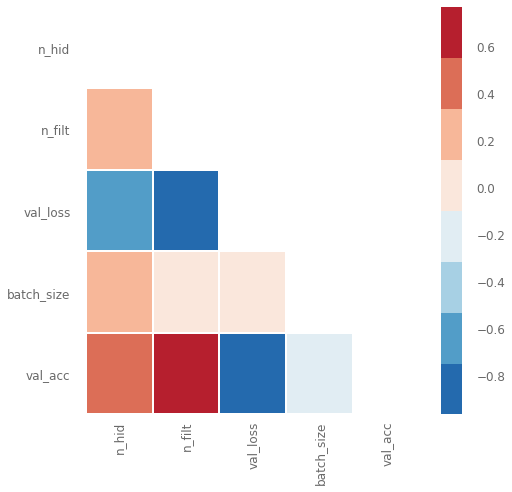

In [43]:
# returns the results dataframe
cnn_lstm_data.plot_corr('val_loss', ['acc', 'loss', 'round_epochs', 'duration', 'drop_prob', 'lr'])

In [44]:
#ast.kde(cnn_lstm_data.data, 'n_hid','val_loss', title="CNN LSTM", x_label="n_hid", y_label="val_loss")
#ast.kde(cnn_lstm_data.data, 'n_filt','val_loss', title="CNN LSTM", x_label="n_filt", y_label="val_loss")

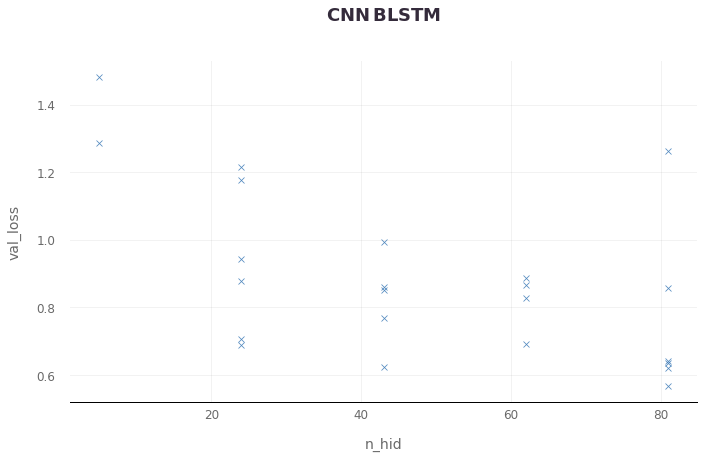

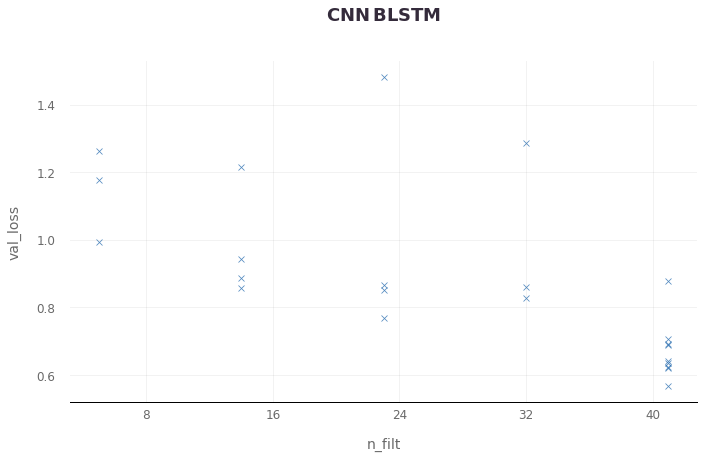

In [45]:
# a regression plot for two dimensions 
ast.regs(cnn_lstm_data.data, 'n_hid', 'val_loss', title="CNN BLSTM", x_label="n_hid", y_label="val_loss")
ast.regs(cnn_lstm_data.data, 'n_filt', 'val_loss', title="CNN BLSTM", x_label="n_filt", y_label="val_loss")

## Part 2
Search parameters:
```
'batch_size': 128    <--- Fix
'lr': [0.0001, 0.0005, 0.001, 0.0015, 0.0020, 0.0025, 0.0030, 0.0035, 0.004, 0.005, 0.007],   
'n_filt': 40    <--- Fix
'n_hid': 80    <--- Fix
'drop_prob': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]  
```



> ## Results



In [46]:
# use Scan object as input
cnn_lstm_data = talos.Analyze(path + "/paper-dataset/CNN_LSTM/052521092813.csv")
# access the dataframe with the results
cnn_lstm_data.data

,round_epochs,loss,acc,val_loss,val_acc,drop_prob,lr
0,120,0.078744,0.976475,0.659007,0.870866,0.4,0.0010
1,120,0.326574,0.900124,0.541774,0.848819,0.7,0.0005
2,120,0.002001,0.999587,1.280385,0.834646,0.1,0.0050
3,120,0.014990,0.997524,1.251024,0.851968,0.7,0.0050
4,120,0.910160,0.692943,0.980387,0.666142,0.6,0.0070
5,120,0.257008,0.919934,0.539453,0.844094,0.6,0.0005
6,120,0.000403,1.000000,1.163522,0.858268,0.1,0.0035
7,120,0.025914,0.992571,1.258301,0.848819,0.7,0.0035
8,120,0.060884,0.981015,0.934073,0.859843,0.6,0.0015
9,120,0.002691,1.000000,1.131788,0.847244,0.2,0.0040


In [47]:
# Minimum val_loss
cnn_lstm_data.data.nsmallest(5, 'val_loss')

,round_epochs,loss,acc,val_loss,val_acc,drop_prob,lr
5,120,0.257008,0.919934,0.539453,0.844094,0.6,0.0005
1,120,0.326574,0.900124,0.541774,0.848819,0.7,0.0005
0,120,0.078744,0.976475,0.659007,0.870866,0.4,0.0010
10,120,0.086827,0.968634,0.703420,0.861417,0.3,0.0015
8,120,0.060884,0.981015,0.934073,0.859843,0.6,0.0015


In [48]:
# Maximum val_accuracy
cnn_lstm_data.data.nlargest(5, 'val_acc')

,round_epochs,loss,acc,val_loss,val_acc,drop_prob,lr
0,120,0.078744,0.976475,0.659007,0.870866,0.4,0.0010
10,120,0.086827,0.968634,0.703420,0.861417,0.3,0.0015
8,120,0.060884,0.981015,0.934073,0.859843,0.6,0.0015
6,120,0.000403,1.000000,1.163522,0.858268,0.1,0.0035
3,120,0.014990,0.997524,1.251024,0.851968,0.7,0.0050


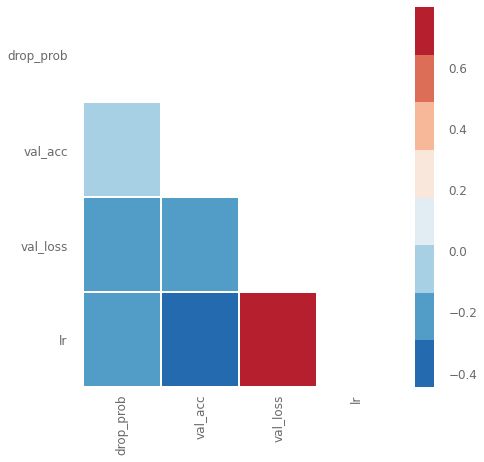

In [49]:
cnn_lstm_data.plot_corr('val_loss', ['acc', 'loss', 'round_epochs', 'duration'])

In [50]:
#ast.kde(cnn_lstm_data.data, 'n_hid','val_loss', title="CNN BLSTM", x_label="n_hid", y_label="val_loss")
#ast.kde(cnn_lstm_data.data, 'lr','val_loss', title="CNN BLSTM", x_label="lr", y_label="val_loss")
#ast.kde(cnn_lstm_data.data, 'batch_size','val_loss', title="CNN BLSTM", x_label="batch_size", y_label="val_loss")

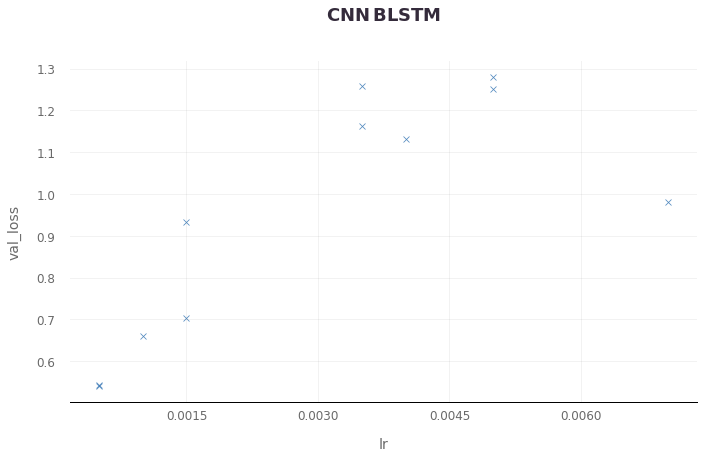

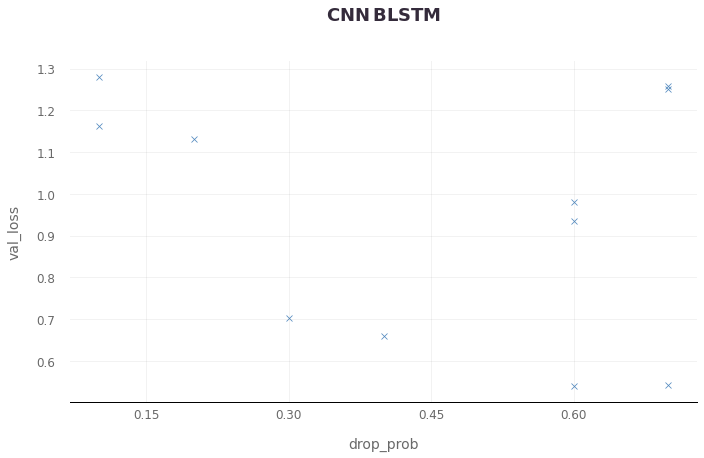

In [51]:
# a regression plot for two dimensions 
ast.regs(cnn_lstm_data.data, 'lr', 'val_loss', title="CNN BLSTM", x_label="lr", y_label="val_loss")
ast.regs(cnn_lstm_data.data, 'drop_prob', 'val_loss', title="CNN BLSTM", x_label="drop_prob", y_label="val_loss")



> ## Results (Our psi-blast dataset)



In [52]:
cnn_lstm_psi = talos.Analyze(path + "/our-psi-blast/CNN_LSTM_psi/060921220449.csv")
# access the dataframe with the results
cnn_lstm_psi_data = cnn_lstm_psi.data.drop(['loss', 'subcellular_loss', 'membrane_loss', 'subcellular_acc', 'membrane_acc'], axis=1)

In [53]:
# Minimum val_loss
cnn_lstm_psi_data.nsmallest(5, 'val_subcellular_loss')

,round_epochs,val_loss,val_subcellular_loss,val_membrane_loss,val_subcellular_acc,val_membrane_acc,batch_size,drop_prob,lr,n_filt,n_hid
18,120,1.583645,1.159216,0.386491,0.625899,0.824141,228,0.3,0.0005,14,43
11,120,1.585109,1.197889,0.397122,0.627498,0.819344,221,0.4,0.0010,14,62
6,120,1.627860,1.226741,0.387631,0.631495,0.836930,130,0.4,0.0020,5,43
3,120,1.725793,1.309019,0.413960,0.594724,0.822542,214,0.3,0.0010,5,62
16,120,1.831492,1.339694,0.489025,0.606715,0.808953,207,0.2,0.0030,5,24


In [54]:
# Maximum val_accuracy
cnn_lstm_psi_data.nlargest(5, 'val_subcellular_acc')

,round_epochs,val_loss,val_subcellular_loss,val_membrane_loss,val_subcellular_acc,val_membrane_acc,batch_size,drop_prob,lr,n_filt,n_hid
22,120,2.745972,1.833764,0.867501,0.641087,0.844924,137,0.6,0.0010,32,62
6,120,1.627860,1.226741,0.387631,0.631495,0.836930,130,0.4,0.0020,5,43
23,120,2.450249,1.762371,0.696876,0.628297,0.816946,221,0.2,0.0025,14,43
11,120,1.585109,1.197889,0.397122,0.627498,0.819344,221,0.4,0.0010,14,62
18,120,1.583645,1.159216,0.386491,0.625899,0.824141,228,0.3,0.0005,14,43


> ## Results (Our one-hot dataset)

In [55]:
cnn_lstm_oh = talos.Analyze(path + "/our-one-hot/CNN_LSTM_oh/070221135742.csv")
# access the dataframe with the results
cnn_lstm_oh_data = cnn_lstm_oh.data.drop(['loss', 'subcellular_loss', 'membrane_loss', 'subcellular_acc', 'membrane_acc'], axis=1)

In [56]:
# Minimum val_loss
cnn_lstm_oh_data.nsmallest(5, 'val_subcellular_loss')

,round_epochs,val_loss,val_subcellular_loss,val_membrane_loss,val_subcellular_acc,val_membrane_acc,batch_size,drop_prob,lr,n_filt,n_hid
24,120,1.958892,1.238732,0.710961,0.552910,0.679894,130,0.1,0.0005,5,62
6,120,2.037298,1.313238,0.721972,0.515873,0.641534,109,0.5,0.0001,23,62
2,120,2.061447,1.359513,0.719828,0.502645,0.681217,46,0.5,0.0001,5,43
17,120,2.154373,1.396715,0.766658,0.498677,0.665344,88,0.5,0.0001,14,43
10,120,2.215416,1.414266,0.797591,0.551587,0.670635,130,0.7,0.0005,23,62


In [57]:
# Maximum val_accuracy
cnn_lstm_oh_data.nlargest(5, 'val_subcellular_acc')

,round_epochs,val_loss,val_subcellular_loss,val_membrane_loss,val_subcellular_acc,val_membrane_acc,batch_size,drop_prob,lr,n_filt,n_hid
20,120,5.313029,2.889171,2.367326,0.571429,0.638889,207,0.1,0.0015,23,81
28,120,2.919987,1.682498,1.276619,0.566138,0.652116,158,0.2,0.0005,23,81
14,120,8.176987,4.661634,3.520043,0.555556,0.629630,193,0.2,0.0035,14,81
25,120,3.353515,2.408146,1.416669,0.554233,0.667989,249,0.6,0.0015,41,43
24,120,1.958892,1.238732,0.710961,0.552910,0.679894,130,0.1,0.0005,5,62



> # BLSTM Attention



Search parameters:


```
'batch_size': (32, 256, 32),
'lr': [0.0001, 0.0005, 0.001, 0.0015, 0.0020, 0.0025, 0.0030, 0.0035, 0.004, 0.005, 0.007],
'n_filt': (5, 50, 5),
'n_hid': (5, 100, 5),
'drop_prob': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
```





> ## Code





```
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

import numpy as np
import talos
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"


config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
_ = tf.compat.v1.Session(config=config)

# Load the encoded protein sequences, labels and masks
# The masks are not needed for the FFN or CNN models
train = np.load('./data/reduced_train.npz')
X_train = train['X_train']
y_train = train['y_train']
mask_train = train['mask_train']
#print(X_train.shape)
#print(X_train)

validation = np.load('./data/reduced_val.npz')
X_val = validation['X_val']
y_val = validation['y_val']
mask_val = validation['mask_val']

p = {
	'batch_size': (32, 256, 32),
	'lr': [0.0001, 0.0005, 0.001, 0.0015, 0.0020, 0.0025, 0.0030, 0.0035, 0.004, 0.005, 0.007],
	'n_filt': (5, 50, 5),
	'n_hid': (5, 100, 5),
	'drop_prob': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
}

experiment_name = "random_search/LSTM_Attention"

class Attention(tf.keras.layers.Layer):
	""" Implementing a layer that does attention according to Bahdanau style """

	def __init__(self, units):
		super(Attention, self).__init__()
		# W1 weight of the previously hidden state(hidden_size x hidden_size)
		self.W1 = tf.keras.layers.Dense(units)
		# W2 weight for all the encoder hidden states
		self.W2 = tf.keras.layers.Dense(units)
		self.V = tf.keras.layers.Dense(1)

	def call(self, inputs, hidden):
		# 'hidden' (h_t) is expanded over the time axis to prepare it for the addition
		# that follows. hidden will always be the last hidden state of the RNN.
		# (in seq2seq in would have been the current state of the decoder step)
		# 'features' (h_s) are all the hidden states of the encoder.
		hidden_with_time_axis = tf.expand_dims(hidden, 1)

		# Bahdanau additive style to compute the score:
		# score = v_a * tanh(W_1*h_t + W_2*h_s)
		score = tf.nn.tanh(self.W1(inputs) + self.W2(hidden_with_time_axis))
		attention_weights = tf.nn.softmax(self.V(score), axis=1)
		context_vector = attention_weights * inputs
		context_vector = tf.reduce_sum(context_vector, axis=1)

		return context_vector, attention_weights

def create_LSTM_Attention(X_train, y_train, X_val, y_val, params):
	# Set hyperparameters

	seq_len = 400
	n_feat = 20
	n_class = 10
	num_epochs = 120

	"""
	Building the network by defining its architecture: an input layer, a bidirectional LSTM, an attention layer,
	a dense layer and an output layer.
	"""

	# Build model
	inputs = keras.Input(shape=(seq_len, n_feat))

	# todo mask here?
	# mask to ignore the padded positions
	#l_mask = layers.Masking(mask_value=0.0, input_shape=(None, n_feat))(inputs)

	# encoders LSTM
	l_lstm, forward_h, forward_c, backward_h, backward_c = layers.Bidirectional \
		(layers.LSTM(params['n_hid'], dropout=params['drop_prob'], return_sequences=True, return_state=True, activation="tanh"))(
		inputs)

	state_h = layers.Concatenate()([forward_h, backward_h])
	state_c = layers.Concatenate()([forward_c, backward_c])

	# Set up the attention layer
	context_vector, attention_weights = Attention(params['n_hid'] * 2)(inputs=l_lstm, hidden=state_h)

	l_drop = layers.Dropout(params['drop_prob'])(context_vector)

	l_out = layers.Dense(n_class, activation="softmax")(l_drop)

	model = keras.Model(inputs, l_out)
	# with clipnorm the gradients will be clipped when their L2 norm exceeds this value.
	model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=params['lr'], clipnorm=3),
					   metrics=['accuracy'])
	history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=params['batch_size'],
						validation_data=(X_val, y_val), shuffle=True)

	return history, model



n_class = 10
y_train = to_categorical(y_train, n_class)
y_val = to_categorical(y_val, n_class)

t = talos.Scan(x=X_train, y=y_train, x_val=X_val, y_val=y_val, params=p, fraction_limit=0.001, model=create_LSTM_Attention, performance_target='val_loss', experiment_name=experiment_name, disable_progress_bar=False, print_params=True)

```





> ## Results



In [58]:
lstm_attention_data = talos.Analyze(path + "/paper-dataset/LSTM_Attention/052621101149.csv")
# access the dataframe with the results
lstm_attention_data.data.head()

,round_epochs,loss,acc,val_loss,val_acc,batch_size,drop_prob,lr,n_filt,n_hid
0,120,0.406116,0.864218,0.515206,0.844094,193,0.1,0.0025,5,62
1,120,0.595686,0.807676,0.556812,0.828346,109,0.5,0.0050,32,24
2,120,0.159835,0.949236,0.442348,0.891339,39,0.3,0.0040,5,81
3,120,0.401337,0.867932,0.475323,0.855118,95,0.5,0.0020,14,81
4,120,0.652850,0.794057,0.590441,0.812598,123,0.7,0.0030,23,81


In [59]:
# Minimum val_loss
lstm_attention_data.data.nsmallest(5, 'val_loss')

,round_epochs,loss,acc,val_loss,val_acc,batch_size,drop_prob,lr,n_filt,n_hid
2,120,0.159835,0.949236,0.442348,0.891339,39,0.3,0.0040,5,81
26,120,0.229978,0.922410,0.453488,0.885039,165,0.4,0.0070,14,81
3,120,0.401337,0.867932,0.475323,0.855118,95,0.5,0.0020,14,81
22,120,0.382737,0.872885,0.478918,0.853543,46,0.5,0.0070,23,62
15,120,0.493355,0.843582,0.481057,0.859843,46,0.6,0.0025,23,81


In [60]:
# Maximum val_accuracy
lstm_attention_data.data.nlargest(5, 'val_acc')

,round_epochs,loss,acc,val_loss,val_acc,batch_size,drop_prob,lr,n_filt,n_hid
2,120,0.159835,0.949236,0.442348,0.891339,39,0.3,0.0040,5,81
26,120,0.229978,0.922410,0.453488,0.885039,165,0.4,0.0070,14,81
21,120,0.191141,0.936442,0.482728,0.866142,235,0.1,0.0035,32,81
15,120,0.493355,0.843582,0.481057,0.859843,46,0.6,0.0025,23,81
3,120,0.401337,0.867932,0.475323,0.855118,95,0.5,0.0020,14,81


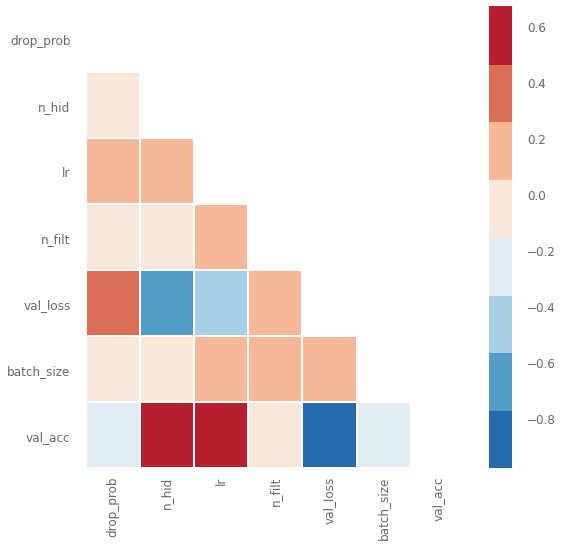

In [61]:
lstm_attention_data.plot_corr('val_loss', ['acc', 'loss', 'round_epochs', 'duration'])

In [62]:
#ast.kde(lstm_attention_data.data, 'n_hid','val_loss', title="A-BLSTM", x_label="n_hid", y_label="val_loss")
#ast.kde(lstm_attention_data.data, 'lr','val_loss', title="A-BLSTM", x_label="lr", y_label="val_loss")

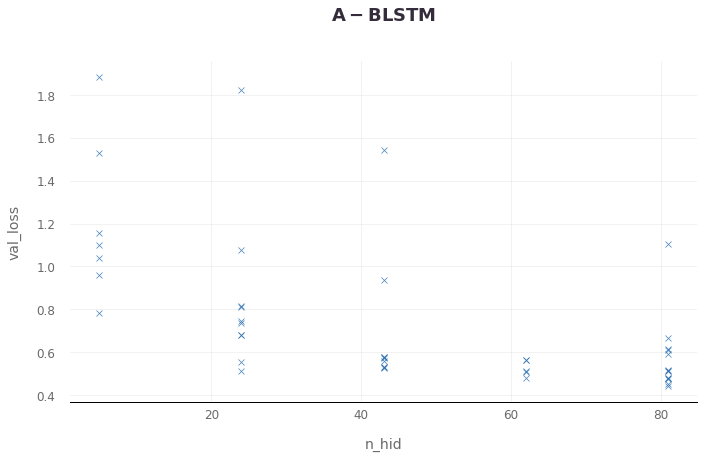

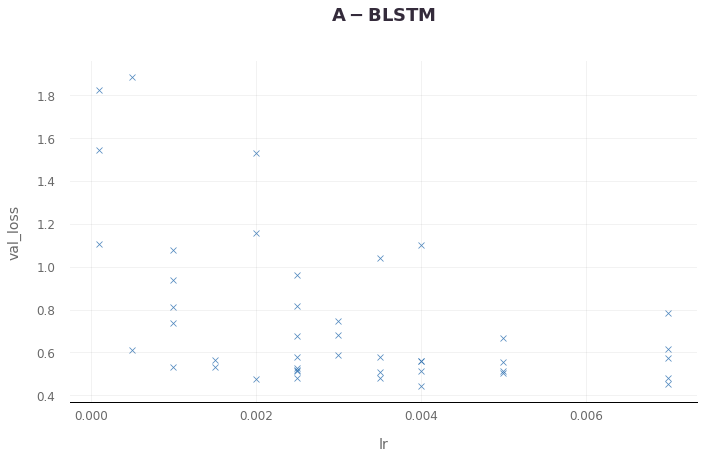

In [63]:
# a regression plot for two dimensions 
ast.regs(lstm_attention_data.data, 'n_hid', 'val_loss', title="A-BLSTM", x_label="n_hid", y_label="val_loss")
ast.regs(lstm_attention_data.data, 'lr', 'val_loss', title="A-BLSTM", x_label="lr", y_label="val_loss")



> ## Results (Our psi-blast dataset)



In [64]:
lstm_attention_psi = talos.Analyze(path + "/our-psi-blast/LSTM_Attention_psi/060821155320.csv")
# access the dataframe with the results
lstm_attention_psi_data = lstm_attention_psi.data.drop(['loss', 'subcellular_loss', 'membrane_loss', 'subcellular_acc', 'membrane_acc'], axis=1)

In [65]:
# Minimum val_loss
lstm_attention_psi_data.nsmallest(5, 'val_subcellular_loss')

,round_epochs,val_loss,val_subcellular_loss,val_membrane_loss,val_subcellular_acc,val_membrane_acc,batch_size,drop_prob,lr,n_hid
1,120,1.438587,1.080177,0.349647,0.667466,0.832134,123,0.6,0.0030,81
4,120,1.475092,1.099104,0.372943,0.668265,0.832134,186,0.4,0.0025,81
12,120,1.576513,1.141715,0.357674,0.626699,0.827338,207,0.6,0.0025,43
13,120,1.612575,1.210397,0.385228,0.597122,0.825739,46,0.5,0.0005,43
9,120,1.614205,1.216606,0.396969,0.625100,0.821743,116,0.4,0.0015,24


In [66]:
# Maximum val_accuracy
lstm_attention_psi_data.nlargest(5, 'val_subcellular_acc')

,round_epochs,val_loss,val_subcellular_loss,val_membrane_loss,val_subcellular_acc,val_membrane_acc,batch_size,drop_prob,lr,n_hid
4,120,1.475092,1.099104,0.372943,0.668265,0.832134,186,0.4,0.0025,81
1,120,1.438587,1.080177,0.349647,0.667466,0.832134,123,0.6,0.0030,81
12,120,1.576513,1.141715,0.357674,0.626699,0.827338,207,0.6,0.0025,43
9,120,1.614205,1.216606,0.396969,0.625100,0.821743,116,0.4,0.0015,24
2,120,1.663861,1.270203,0.391897,0.602718,0.821743,235,0.5,0.0010,62


> ## Results (Our one-hot dataset)

In [67]:
lstm_attention_oh = talos.Analyze(path + "/our-one-hot/LSTM_Attention_oh/070221140440.csv")
# access the dataframe with the results
lstm_attention_oh_data = lstm_attention_oh.data.drop(['loss', 'subcellular_loss', 'membrane_loss', 'subcellular_acc', 'membrane_acc'], axis=1)

In [68]:
# Minimum val_loss
lstm_attention_oh_data.nsmallest(5, 'val_subcellular_loss')

,round_epochs,val_loss,val_subcellular_loss,val_membrane_loss,val_subcellular_acc,val_membrane_acc,batch_size,drop_prob,lr,n_hid
8,120,1.782417,1.006031,0.597355,0.589947,0.699735,186,0.3,0.0010,62
1,120,1.734622,1.071176,0.644252,0.626984,0.726190,53,0.2,0.0020,24
16,120,1.759700,1.075706,0.657408,0.597884,0.706349,235,0.2,0.0025,81
18,120,1.760737,1.090555,0.657670,0.611111,0.714286,53,0.1,0.0015,24
19,120,1.785060,1.111932,0.671598,0.634921,0.694444,95,0.2,0.0030,24


In [69]:
# Maximum val_accuracy
lstm_attention_oh_data.nlargest(5, 'val_subcellular_acc')

,round_epochs,val_loss,val_subcellular_loss,val_membrane_loss,val_subcellular_acc,val_membrane_acc,batch_size,drop_prob,lr,n_hid
7,120,1.800895,1.115109,0.683580,0.641534,0.719577,81,0.4,0.0035,43
19,120,1.785060,1.111932,0.671598,0.634921,0.694444,95,0.2,0.0030,24
22,120,1.763468,1.194323,0.633920,0.628307,0.706349,249,0.1,0.0040,24
1,120,1.734622,1.071176,0.644252,0.626984,0.726190,53,0.2,0.0020,24
9,120,1.776379,1.130183,0.673704,0.613757,0.710317,116,0.5,0.0035,81




> # CNN BLSTM Attention



Search parameters:


```
'batch_size': (32, 256, 32),
'lr': [0.0001, 0.0005, 0.001, 0.0015, 0.0020, 0.0025, 0.0030, 0.0035, 0.004, 0.005, 0.007],
'n_filt': (5, 50, 5),
'n_hid': (5, 100, 5),
'drop_prob': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
```





> ## Code





```
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

import numpy as np
import talos
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"


config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
_ = tf.compat.v1.Session(config=config)

# Load the encoded protein sequences, labels and masks
# The masks are not needed for the FFN or CNN models
train = np.load('./data/reduced_train.npz')
X_train = train['X_train']
y_train = train['y_train']
mask_train = train['mask_train']
#print(X_train.shape)
#print(X_train)

validation = np.load('./data/reduced_val.npz')
X_val = validation['X_val']
y_val = validation['y_val']
mask_val = validation['mask_val']

p = {
	'batch_size': (32, 256, 32),
	'lr': [0.0001, 0.0005, 0.001, 0.0015, 0.0020, 0.0025, 0.0030, 0.0035, 0.004, 0.005, 0.007],
	'n_filt': (5, 50, 5),
	'n_hid': (5, 100, 5),
	'drop_prob': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
}

experiment_name = "random_search/CNN_LSTM_Attention"

class Attention(tf.keras.layers.Layer):
	""" Implementing a layer that does attention according to Bahdanau style """

	def __init__(self, units):
		super(Attention, self).__init__()
		# W1 weight of the previously hidden state(hidden_size x hidden_size)
		self.W1 = tf.keras.layers.Dense(units)
		# W2 weight for all the encoder hidden states
		self.W2 = tf.keras.layers.Dense(units)
		self.V = tf.keras.layers.Dense(1)

	def call(self, inputs, hidden):
		# 'hidden' (h_t) is expanded over the time axis to prepare it for the addition
		# that follows. hidden will always be the last hidden state of the RNN.
		# (in seq2seq in would have been the current state of the decoder step)
		# 'features' (h_s) are all the hidden states of the encoder.
		hidden_with_time_axis = tf.expand_dims(hidden, 1)

		# Bahdanau additive style to compute the score:
		# score = v_a * tanh(W_1*h_t + W_2*h_s)
		score = tf.nn.tanh(self.W1(inputs) + self.W2(hidden_with_time_axis))
		attention_weights = tf.nn.softmax(self.V(score), axis=1)
		context_vector = attention_weights * inputs
		context_vector = tf.reduce_sum(context_vector, axis=1)

		return context_vector, attention_weights

def create_CNN_LSTM_Attention(X_train, y_train, X_val, y_val, params):
	# Set hyperparameters

	seq_len = 400
	n_feat = 20
	n_class = 10
	num_epochs = 120

	"""
	Building the network by defining its architecture: an input layer, two convolutional layers, a bidirectional
	LSTM, an attention layer, a dense layer and an output layer.
	"""

	# Build model
	inputs = keras.Input(shape=(seq_len, n_feat))

	l_permute = layers.Permute((2, 1))(inputs)

	l_conv_a = layers.Conv1D(params['n_filt'], 3, strides=1, padding="same", activation="relu",
							 data_format='channels_first')(
		l_permute)
	l_conv_b = layers.Conv1D(params['n_filt'], 5, strides=1, padding="same", activation="relu",
							 data_format='channels_first')(
		l_permute)
	l_conc = tf.keras.layers.Concatenate(axis=1)([l_conv_a, l_conv_b])

	l_conv_final = layers.Conv1D(
		params['n_filt'] * 2, 3, strides=1, padding="same", activation="relu", data_format='channels_first')(l_conc)

	l_reshu = layers.Permute((2, 1))(l_conv_final)

	# encoders LSTM
	l_lstm, forward_h, forward_c, backward_h, backward_c = layers.Bidirectional \
		(layers.LSTM(params['n_hid'], dropout=params['drop_prob'], return_sequences=True, return_state=True, activation="tanh"))(
		l_reshu)

	state_h = layers.Concatenate()([forward_h, backward_h])
	state_c = layers.Concatenate()([forward_c, backward_c])

	# Set up the attention layer
	context_vector, attention_weights = Attention(params['n_hid'] * 2)(inputs=l_lstm, hidden=state_h)

	l_drop = layers.Dropout(params['drop_prob'])(context_vector)

	l_dense = layers.Dense(params['n_hid'] * 2, activation="relu")(l_drop)

	l_out = layers.Dense(n_class, activation="softmax")(l_dense)

	model = keras.Model(inputs, l_out)
	# with clipnorm the gradients will be clipped when their L2 norm exceeds this value.
	model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=params['lr'], clipnorm=3),
					   metrics=['accuracy'])
	history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=params['batch_size'],
						validation_data=(X_val, y_val), shuffle=True)

	return history, model


n_class = 10
y_train = to_categorical(y_train, n_class)
y_val = to_categorical(y_val, n_class)

t = talos.Scan(x=X_train, y=y_train, x_val=X_val, y_val=y_val, params=p, fraction_limit=0.001, model=create_CNN_LSTM_Attention, performance_target='val_loss', experiment_name=experiment_name, disable_progress_bar=False, print_params=True)

```





> ## Results (Paper Dataset)



In [70]:
cnn_lstm_attention_data = talos.Analyze(path + "/paper-dataset/CNN_LSTM_Attention/052721171119.csv")

In [71]:
# Minimum val_loss
cnn_lstm_attention_data.data.nsmallest(5, 'val_loss')

,round_epochs,loss,acc,val_loss,val_acc,batch_size,drop_prob,lr,n_filt,n_hid
31,120,0.171698,0.946826,0.426601,0.881928,39,0.3,0.0020,41,81
4,120,0.178189,0.942220,0.474817,0.883465,137,0.2,0.0015,23,24
9,120,0.248480,0.917045,0.513722,0.872441,221,0.3,0.0015,23,62
36,120,0.373430,0.875774,0.528875,0.842520,193,0.4,0.0005,14,81
1,120,0.224905,0.924061,0.564301,0.855118,200,0.1,0.0005,41,43


In [72]:
# Maximum val_accuracy
cnn_lstm_attention_data.data.nlargest(5, 'val_acc')

,round_epochs,loss,acc,val_loss,val_acc,batch_size,drop_prob,lr,n_filt,n_hid
4,120,0.178189,0.942220,0.474817,0.883465,137,0.2,0.0015,23,24
39,120,0.053429,0.984317,0.789135,0.883465,109,0.1,0.0070,14,62
31,120,0.171698,0.946826,0.426601,0.881928,39,0.3,0.0020,41,81
8,120,0.114742,0.960380,0.669125,0.880315,81,0.4,0.0015,14,62
0,120,0.081111,0.971936,0.770632,0.872441,32,0.2,0.0070,41,81


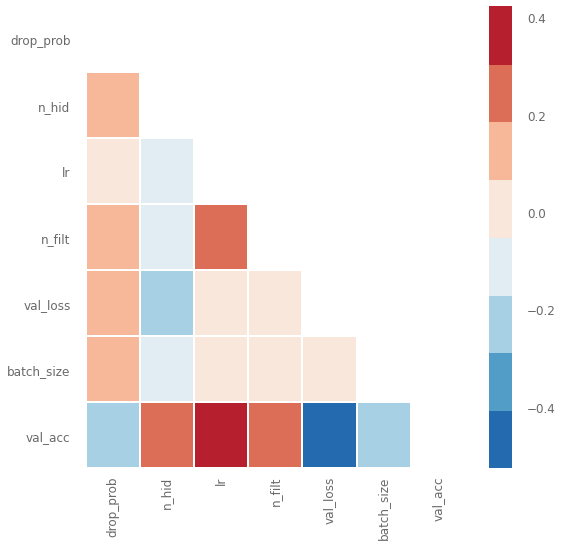

In [73]:
cnn_lstm_attention_data.plot_corr('val_loss', ['acc', 'loss', 'round_epochs', 'duration'])

In [74]:
#ast.kde(cnn_lstm_attention_data.data, 'n_hid','val_loss', title="CNN A-BLSTM", x_label="n_hid", y_label="val_loss")
#ast.kde(cnn_lstm_attention_data.data, 'lr','val_loss', title="CNN A-BLSTM", x_label="lr", y_label="val_loss")

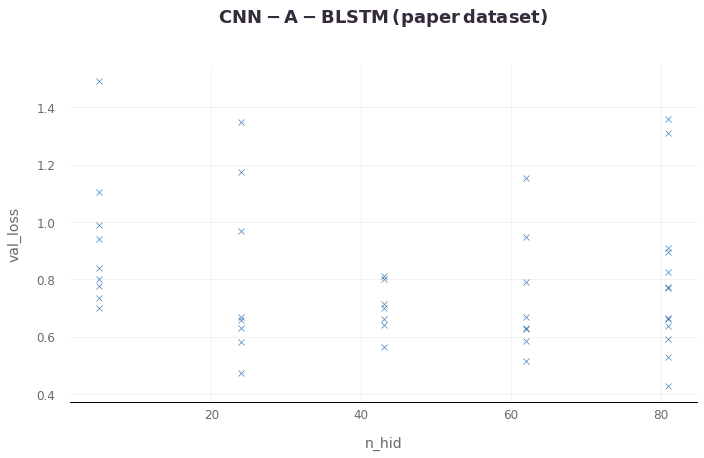

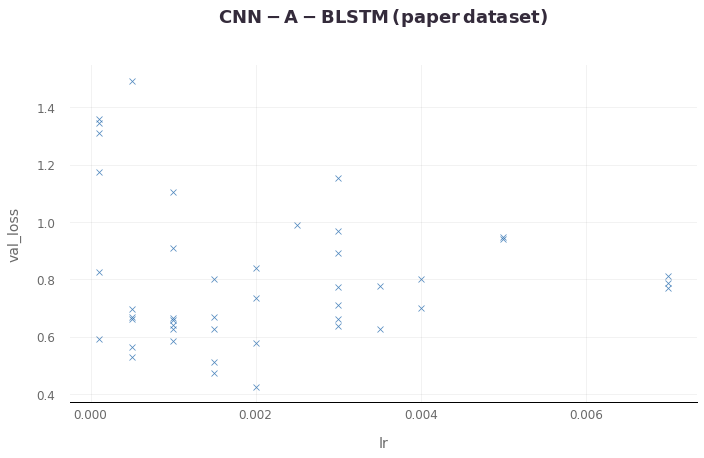

In [75]:
# a regression plot for two dimensions 
ast.regs(cnn_lstm_attention_data.data, 'n_hid', 'val_loss', title="CNN-A-BLSTM (paper dataset)", x_label="n_hid", y_label="val_loss")
ast.regs(cnn_lstm_attention_data.data, 'lr', 'val_loss', title="CNN-A-BLSTM (paper dataset)", x_label="lr", y_label="val_loss")



> ## Results (Our one-hot Dataset)



In [76]:
cnn_lstm_attention_oh = talos.Analyze(path + "/our-one-hot/CNN_LSTM_Attention_one_hot/060121113237.csv")
# access the dataframe with the results
cnn_lstm_attention_oh_data = cnn_lstm_attention_oh.data.drop(['loss', 'subcellular_loss', 'membrane_loss', 'subcellular_acc', 'membrane_acc'], axis=1)

In [77]:
# Minimum val_loss
cnn_lstm_attention_oh_data.nsmallest(5, 'val_subcellular_loss')

,round_epochs,val_loss,val_subcellular_loss,val_membrane_loss,val_subcellular_acc,val_membrane_acc,batch_size,drop_prob,lr,n_filt,n_hid
24,120,2.058563,1.311366,0.726291,0.513405,0.660858,172,0.7,0.0020,5,24
42,120,2.026549,1.312962,0.732398,0.536193,0.678284,172,0.3,0.0001,43,62
13,120,2.101743,1.325175,0.717419,0.517426,0.668901,228,0.1,0.0001,62,24
2,120,2.048859,1.346244,0.714116,0.517426,0.666220,130,0.1,0.0001,43,24
31,120,2.092361,1.379675,0.701207,0.516086,0.662198,179,0.1,0.0010,5,5


In [78]:
# Maximum val_accuracy
cnn_lstm_attention_oh_data.nlargest(5, 'val_subcellular_acc')

,round_epochs,val_loss,val_subcellular_loss,val_membrane_loss,val_subcellular_acc,val_membrane_acc,batch_size,drop_prob,lr,n_filt,n_hid
17,120,2.711149,1.582123,1.033665,0.577748,0.664879,235,0.1,0.0005,81,62
40,120,5.336738,3.202042,2.183153,0.550938,0.640751,46,0.1,0.0025,5,81
20,120,5.185370,3.070966,2.123864,0.544236,0.638070,151,0.2,0.0010,62,62
49,120,2.814771,1.827030,1.032305,0.538874,0.640751,60,0.6,0.0030,5,81
42,120,2.026549,1.312962,0.732398,0.536193,0.678284,172,0.3,0.0001,43,62




> ## Results (Our psi-blast Dataset)



In [79]:
cnn_lstm_attention_psi = talos.Analyze(path + "/our-psi-blast/CNN_LSTM_Attention_psi/061121083008.csv")
# access the dataframe with the results
cnn_lstm_attention_psi_data = cnn_lstm_attention_psi.data.drop(['loss', 'subcellular_loss', 'membrane_loss', 'subcellular_acc', 'membrane_acc'], axis=1)

In [80]:
# Minimum val_loss
cnn_lstm_attention_psi_data.nsmallest(5, 'val_subcellular_loss')

,round_epochs,val_loss,val_subcellular_loss,val_membrane_loss,val_subcellular_acc,val_membrane_acc,batch_size,drop_prob,lr,n_filt,n_hid
7,120,1.523029,1.110763,0.365141,0.672262,0.846523,165,0.3,0.0005,23,24
20,120,1.590532,1.168623,0.419032,0.669065,0.840927,165,0.2,0.0005,32,43
19,120,1.606578,1.254819,0.370491,0.604317,0.844924,200,0.5,0.0010,14,24
3,120,1.802427,1.326340,0.473295,0.629097,0.822542,60,0.6,0.0005,14,81
18,120,1.720004,1.336298,0.383699,0.566747,0.832134,179,0.3,0.0001,32,43


In [81]:
# Maximum val_accuracy
cnn_lstm_attention_psi_data.nlargest(5, 'val_subcellular_acc')

,round_epochs,val_loss,val_subcellular_loss,val_membrane_loss,val_subcellular_acc,val_membrane_acc,batch_size,drop_prob,lr,n_filt,n_hid
7,120,1.523029,1.110763,0.365141,0.672262,0.846523,165,0.3,0.0005,23,24
9,120,3.266732,2.209129,0.980567,0.671463,0.843325,165,0.1,0.0015,23,81
20,120,1.590532,1.168623,0.419032,0.669065,0.840927,165,0.2,0.0005,32,43
6,120,3.551641,2.347900,1.201064,0.645084,0.815348,53,0.2,0.0025,32,24
17,120,2.228381,1.591410,0.630560,0.644285,0.819344,144,0.5,0.0020,14,81


> # CNN BLSTM Attention Complete (fixed train val)



> ## Results (Paper Dataset)



In [82]:
cnn_lstm_attention_paper_complete_fixed = talos.Analyze(path + "/paper-dataset/CNN_LSTM_Attention_paper_fixedTrainVal/061721193110.csv")
# access the dataframe with the results
cnn_lstm_attention_paper_complete_fixed_data = cnn_lstm_attention_paper_complete_fixed.data.drop(['loss'], axis=1)

In [83]:
# Minimum val_loss
cnn_lstm_attention_paper_complete_fixed_data.nsmallest(5, 'val_loss')

,round_epochs,acc,val_loss,val_acc,batch_size,drop_hid,drop_prob,lr,n_filt,n_hid
8,200,0.972973,1.142546,0.774160,123,0.1,0.6,0.0005,41,24
7,200,0.552873,1.161214,0.565126,46,0.5,0.5,0.0040,32,5
6,200,0.516925,1.306702,0.565126,242,0.6,0.7,0.0001,5,62
11,200,0.826555,1.333623,0.721639,151,0.2,0.6,0.0050,23,5
0,200,0.938861,1.373400,0.776260,102,0.4,0.6,0.0035,23,24


In [84]:
# Maximum val_accuracy
cnn_lstm_attention_paper_complete_fixed_data.nlargest(5, 'val_acc')

,round_epochs,acc,val_loss,val_acc,batch_size,drop_hid,drop_prob,lr,n_filt,n_hid
2,200,0.959591,1.518087,0.780462,144,0.5,0.6,0.0025,32,43
10,200,0.976909,1.481579,0.777311,207,0.1,0.4,0.0070,41,81
0,200,0.938861,1.373400,0.776260,102,0.4,0.6,0.0035,23,24
8,200,0.972973,1.142546,0.774160,123,0.1,0.6,0.0005,41,24
15,200,0.980058,1.472425,0.756303,200,0.1,0.6,0.0040,14,43


> ## Results (Multiloc Dataset)

In [85]:
cnn_lstm_attention_multiloc_complete_fixed = talos.Analyze(path + "/multiloc/CNN_LSTM_Attention_multiloc_fixedTrainVal/061821202250.csv")
# access the dataframe with the results
cnn_lstm_attention_multiloc_complete_fixed_data = cnn_lstm_attention_multiloc_complete_fixed.data.drop(['loss'], axis=1)

In [86]:
# Minimum val_loss
cnn_lstm_attention_multiloc_complete_fixed_data.nsmallest(5, 'val_loss')

,round_epochs,acc,val_loss,val_acc,batch_size,drop_hid,drop_prob,lr,n_filt,n_hid
28,120,0.711251,0.917285,0.697796,200,0.1,0.6,0.0010,5,5
9,120,0.818778,0.924133,0.717734,228,0.1,0.1,0.0001,14,43
20,120,0.598479,1.001857,0.648478,67,0.6,0.7,0.0050,23,43
1,120,0.661946,1.020530,0.671563,95,0.7,0.6,0.0010,41,24
22,120,0.825597,1.058416,0.754460,137,0.5,0.6,0.0050,23,43


In [87]:
# Maximum val_accuracy
cnn_lstm_attention_multiloc_complete_fixed_data.nlargest(5, 'val_acc')

,round_epochs,acc,val_loss,val_acc,batch_size,drop_hid,drop_prob,lr,n_filt,n_hid
15,120,0.977446,1.417376,0.790136,116,0.4,0.3,0.0015,41,43
6,120,0.964857,1.302126,0.789087,60,0.4,0.4,0.0025,32,62
17,120,0.965906,1.237837,0.775446,60,0.2,0.5,0.0010,23,24
21,120,0.974036,1.350301,0.768101,228,0.1,0.3,0.0070,14,62
2,120,0.966693,1.340451,0.764953,95,0.2,0.4,0.0035,23,62


> ## Results (Our psi-blast Dataset)

In [88]:
cnn_lstm_attention_psi_complete_fixed = talos.Analyze(path + "/our-psi-blast/CNN_LSTM_Attention_psi_fixedTrainVal/061521094623.csv")
# access the dataframe with the results
cnn_lstm_attention_psi_complete_fixed_data = cnn_lstm_attention_psi_complete_fixed.data.drop(['loss', 'subcellular_loss', 'membrane_loss', 'subcellular_acc', 'membrane_acc'], axis=1)

In [89]:
# Minimum val_loss
cnn_lstm_attention_psi_complete_fixed_data.nsmallest(5, 'val_subcellular_loss')

,round_epochs,val_loss,val_subcellular_loss,val_membrane_loss,val_subcellular_acc,val_membrane_acc,batch_size,drop_hid,drop_prob,lr,n_filt,n_hid
16,200,2.497517,1.799022,0.719682,0.471227,0.731813,242,0.2,0.5,0.0001,5,43
0,200,2.564877,1.966477,0.596996,0.412595,0.667752,95,0.7,0.7,0.0001,32,5
22,200,2.921607,2.033739,0.874287,0.437568,0.770901,67,0.6,0.2,0.0001,32,62
37,200,2.989387,2.093144,0.845909,0.439739,0.747014,207,0.7,0.2,0.0001,23,43
18,200,3.043324,2.204547,0.833256,0.457112,0.692725,193,0.7,0.7,0.0050,32,81


In [90]:
# Maximum val_accuracy
cnn_lstm_attention_psi_complete_fixed_data.nlargest(5, 'val_subcellular_acc')

,round_epochs,val_loss,val_subcellular_loss,val_membrane_loss,val_subcellular_acc,val_membrane_acc,batch_size,drop_hid,drop_prob,lr,n_filt,n_hid
26,200,3.454184,2.446520,1.021964,0.656895,0.826276,242,0.2,0.5,0.0015,32,62
33,200,3.385972,2.266385,1.134937,0.633008,0.790445,249,0.1,0.5,0.0010,14,62
20,200,4.557688,3.110861,1.437565,0.622150,0.803474,186,0.4,0.2,0.0035,32,81
17,200,3.763047,2.739430,1.013480,0.618893,0.815418,165,0.2,0.3,0.0010,32,24
21,200,3.388975,2.515792,0.873129,0.618893,0.817590,186,0.2,0.4,0.0030,41,43




> # Comparison (Paper Dataset)



Finally, we plot the loss and the accuracy for each model.

In [91]:
# Loss
err_ffn = ffn_data.data.nsmallest(5, 'val_loss').val_loss.values[0]
err_cnn = cnn_data.data.nsmallest(5, 'val_loss').val_loss.values[0]
err_lstm = lstm_data.data.nsmallest(5, 'val_loss').val_loss.values[0]
err_cnn_lstm = cnn_lstm_data.data.nsmallest(5, 'val_loss').val_loss.values[0]
err_lstm_attention = lstm_attention_data.data.nsmallest(5, 'val_loss').val_loss.values[0]
err_cnn_lstm_attention = cnn_lstm_attention_data.data.nsmallest(5, 'val_loss').val_loss.values[0]
err_cnn_lstm_attention_paper_complete = cnn_lstm_attention_paper_complete_fixed.data.nsmallest(5, 'val_loss').val_loss.values[0]
# Accuracy
acc_ffn = ffn_data.data.nsmallest(5, 'val_loss').val_acc.values[0]
acc_cnn = cnn_data.data.nsmallest(5, 'val_loss').val_acc.values[0]
acc_lstm = lstm_data.data.nsmallest(5, 'val_loss').val_acc.values[0]
acc_cnn_lstm = cnn_lstm_data.data.nsmallest(5, 'val_loss').val_acc.values[0]
acc_lstm_attention = lstm_attention_data.data.nsmallest(5, 'val_loss').val_acc.values[0]
acc_cnn_lstm_attention = cnn_lstm_attention_data.data.nsmallest(5, 'val_loss').val_acc.values[0]
err_cnn_lstm_attention_paper_complete = cnn_lstm_attention_paper_complete_fixed.data.nsmallest(5, 'val_loss').val_acc.values[0]

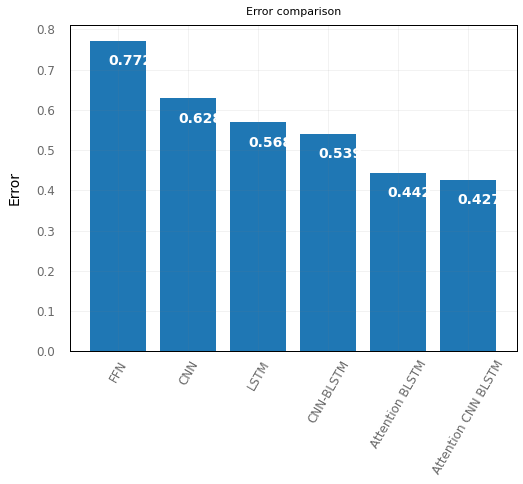

In [92]:
plt.figure(figsize=(8,6))
x = np.arange(6)
errors_paper = [err_ffn,err_cnn,err_lstm,err_cnn_lstm,err_lstm_attention,err_cnn_lstm_attention]
plt.bar(x, errors_paper)
plt.title('Error comparison')
plt.ylabel('Error')
plt.xticks(x, ['FFN','CNN','LSTM','CNN-BLSTM','Attention BLSTM','Attention CNN BLSTM'], rotation=60)
for i, v in enumerate(errors_paper):
    plt.text(i-0.15,v-0.06, '%.3f' % v, color='white',fontweight='bold');

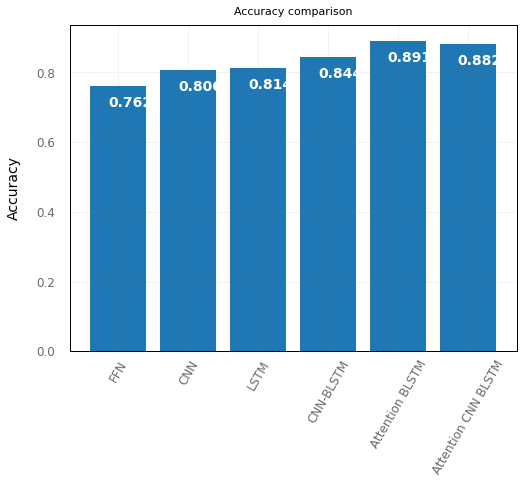

In [93]:
plt.figure(figsize=(8,6))
x = np.arange(6)
accuracies_paper = [acc_ffn,acc_cnn,acc_lstm,acc_cnn_lstm,acc_lstm_attention, acc_cnn_lstm_attention]
plt.bar(x, accuracies_paper)
plt.title('Accuracy comparison')
plt.ylabel('Accuracy')
plt.xticks(x, ['FFN','CNN','LSTM','CNN-BLSTM','Attention BLSTM', 'Attention CNN BLSTM'], rotation=60)
for i, v in enumerate(accuracies_paper):
    plt.text(i-0.15,v-0.06, '%.3f' % v, color='white',fontweight='bold');



> # Comparison (Our one-hot)



In [94]:
# Loss
err_ffn_oh = ffn_oh.data.nsmallest(5, 'val_subcellular_loss').val_subcellular_loss.values[0]
err_cnn_oh = cnn_oh.data.nsmallest(5, 'val_subcellular_loss').val_subcellular_loss.values[0]
err_lstm_oh = lstm_oh.data.nsmallest(5, 'val_subcellular_loss').val_subcellular_loss.values[0]
err_cnn_lstm_oh = cnn_lstm_oh.data.nsmallest(5, 'val_subcellular_loss').val_subcellular_loss.values[0]
err_lstm_attention_oh = lstm_attention_oh.data.nsmallest(5, 'val_subcellular_loss').val_subcellular_loss.values[0]
err_cnn_lstm_attention_oh = cnn_lstm_attention_oh.data.nsmallest(5, 'val_subcellular_loss').val_subcellular_loss.values[0]
# Accuracy
acc_ffn_oh = ffn_oh.data.nsmallest(5, 'val_subcellular_loss').val_subcellular_acc.values[0]
acc_cnn_oh = cnn_oh.data.nsmallest(5, 'val_subcellular_loss').val_subcellular_acc.values[0]
acc_lstm_oh = lstm_oh.data.nsmallest(5, 'val_subcellular_loss').val_subcellular_acc.values[0]
acc_cnn_lstm_oh = cnn_lstm_oh.data.nsmallest(5, 'val_subcellular_loss').val_subcellular_acc.values[0]
acc_lstm_attention_oh = lstm_attention_oh.data.nsmallest(5, 'val_subcellular_loss').val_subcellular_acc.values[0]
acc_cnn_lstm_attention_oh = cnn_lstm_attention_oh.data.nsmallest(5, 'val_subcellular_loss').val_subcellular_acc.values[0]

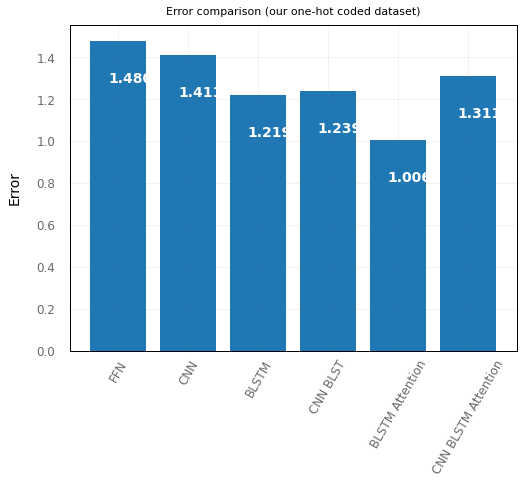

In [95]:
plt.figure(figsize=(8,6))
x = np.arange(6)
errors_oh = [err_ffn_oh,err_cnn_oh,err_lstm_oh,err_cnn_lstm_oh,err_lstm_attention_oh,err_cnn_lstm_attention_oh]
plt.bar(x, errors_oh)
plt.title('Error comparison (our one-hot coded dataset)')
plt.ylabel('Error')
plt.xticks(x, ['FFN','CNN', 'BLSTM', 'CNN BLST', 'BLSTM Attention', 'CNN BLSTM Attention', 'CNN BLSTM Attention complete'], rotation=60)
for i, v in enumerate(errors_oh):
    plt.text(i-0.15,v-0.2, '%.3f' % v, color='white',fontweight='bold');

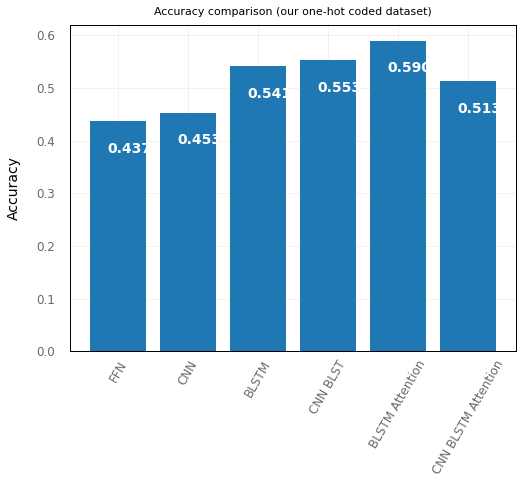

In [96]:
plt.figure(figsize=(8,6))
x = np.arange(6)
accuracies_oh = [acc_ffn_oh, acc_cnn_oh, acc_lstm_oh, acc_cnn_lstm_oh, acc_lstm_attention_oh, acc_cnn_lstm_attention_oh]
plt.bar(x, accuracies_oh)
plt.title('Accuracy comparison (our one-hot coded dataset)')
plt.ylabel('Accuracy')
plt.xticks(x, ['FFN','CNN', 'BLSTM', 'CNN BLST', 'BLSTM Attention', 'CNN BLSTM Attention', 'CNN BLSTM Attention complete'], rotation=60)
for i, v in enumerate(accuracies_oh):
    plt.text(i-0.15,v-0.06, '%.3f' % v, color='white',fontweight='bold');



> # Comparison (Our psi-blast)



In [97]:
# Loss
err_ffn_psi = ffn_psi.data.nsmallest(5, 'val_subcellular_loss').val_subcellular_loss.values[0]
err_cnn_psi = cnn_psi.data.nsmallest(5, 'val_subcellular_loss').val_subcellular_loss.values[0]
err_lstm_psi = lstm_psi.data.nsmallest(5, 'val_subcellular_loss').val_subcellular_loss.values[0]
err_cnn_lstm_psi = cnn_lstm_psi.data.nsmallest(5, 'val_subcellular_loss').val_subcellular_loss.values[0]
err_lstm_attention_psi = lstm_attention_psi.data.nsmallest(5, 'val_subcellular_loss').val_subcellular_loss.values[0]
err_cnn_lstm_attention_psi = cnn_lstm_attention_psi.data.nsmallest(5, 'val_subcellular_loss').val_subcellular_loss.values[0]
err_cnn_lstm_attention_psi_complete_fixed = cnn_lstm_attention_psi_complete_fixed.data.nsmallest(5, 'val_subcellular_loss').val_subcellular_loss.values[0]
# Accuracy
acc_ffn_psi = ffn_psi.data.nsmallest(5, 'val_subcellular_loss').val_subcellular_acc.values[0]
acc_cnn_psi = cnn_psi.data.nsmallest(5, 'val_subcellular_loss').val_subcellular_acc.values[0]
acc_lstm_psi = lstm_psi.data.nsmallest(5, 'val_subcellular_loss').val_subcellular_acc.values[0]
acc_cnn_lstm_psi = cnn_lstm_psi.data.nsmallest(5, 'val_subcellular_loss').val_subcellular_acc.values[0]
acc_lstm_attention_psi = lstm_attention_psi.data.nsmallest(5, 'val_subcellular_loss').val_subcellular_acc.values[0]
acc_cnn_lstm_attention_psi = cnn_lstm_attention_psi.data.nsmallest(5, 'val_subcellular_loss').val_subcellular_acc.values[0]
acc_cnn_lstm_attention_psi_complete_fixed = cnn_lstm_attention_psi_complete_fixed.data.nsmallest(5, 'val_subcellular_loss').val_subcellular_acc.values[0]

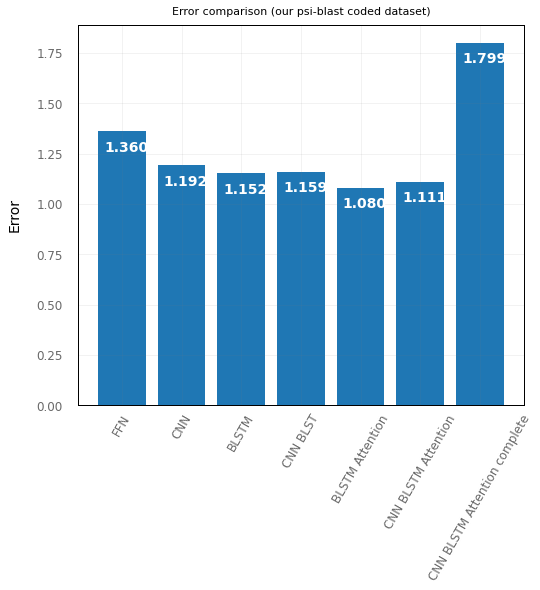

In [98]:
plt.figure(figsize=(8,7))
x = np.arange(7)
errors_psi = [err_ffn_psi,err_cnn_psi,err_lstm_psi,err_cnn_lstm_psi,err_lstm_attention_psi,err_cnn_lstm_attention_psi, err_cnn_lstm_attention_psi_complete_fixed]
plt.bar(x, errors_psi)
plt.title('Error comparison (our psi-blast coded dataset)')
plt.ylabel('Error')
plt.xticks(x, ['FFN','CNN', 'BLSTM', 'CNN BLST', 'BLSTM Attention', 'CNN BLSTM Attention', 'CNN BLSTM Attention complete'], rotation=60)
for i, v in enumerate(errors_psi):
    plt.text(i-0.30,v-0.1, '%.3f' % v, color='white',fontweight='bold');

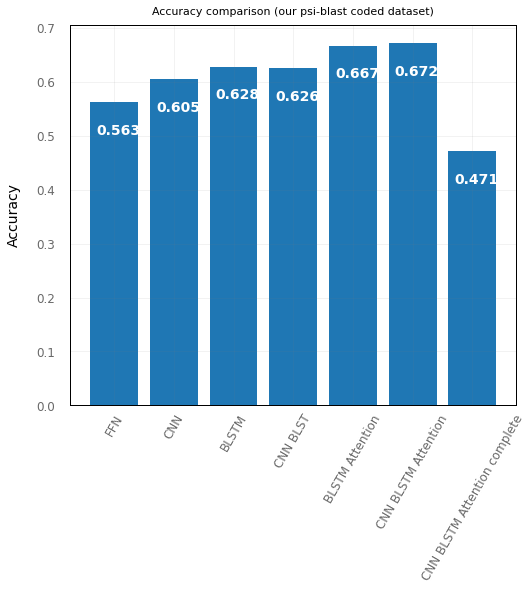

In [99]:
plt.figure(figsize=(8,7))
x = np.arange(7)
accuracies_psi = [acc_ffn_psi, acc_cnn_psi, acc_lstm_psi,acc_cnn_lstm_psi, acc_lstm_attention_psi, acc_cnn_lstm_attention_psi, acc_cnn_lstm_attention_psi_complete_fixed]
plt.bar(x, accuracies_psi)
plt.title('Accuracy comparison (our psi-blast coded dataset)')
plt.ylabel('Accuracy')
plt.xticks(x, ['FFN', 'CNN', 'BLSTM', 'CNN BLST', 'BLSTM Attention', 'CNN BLSTM Attention', 'CNN BLSTM Attention complete'], rotation=60)
for i, v in enumerate(accuracies_psi):
    plt.text(i-0.30,v-0.06, '%.3f' % v, color='white',fontweight='bold');

# All comparisons

In [100]:
bar_font_size = 15
lagend_size = 20
label_size = 20



> ## Subcellular



In [101]:
import plotly.graph_objects as go
from plotly.graph_objs import *

labels = ['FFN','CNN', 'BLSTM', 'CNN BLST', 'BLSTM Attention', 'CNN BLSTM Attention']
width = 0.25

errors_oh = [err_ffn_oh, err_cnn_oh, err_lstm_oh, err_cnn_lstm_oh, err_lstm_attention_oh, err_cnn_lstm_attention_oh]

fig = go.Figure(data=[
    go.Bar(name='our one-hot 400 dataset', x=labels, y=errors_oh, text=np.round(errors_oh, 4), textposition='outside',  width=width, marker_color='#b0cffe', textfont_size=bar_font_size),
    go.Bar(name='our psi-blast 400 dataset', x=labels, y=errors_psi, text=np.round(errors_psi, 4), textposition='outside', width=width, marker_color='#fcb96b', textfont_size=bar_font_size),
    go.Bar(name='paper 400 dataset', x=labels, y=errors_paper, text=np.round(errors_paper, 4), textposition='outside',  width=width, marker_color='#ccfca6', textfont_size=bar_font_size),
], layout=Layout(
    paper_bgcolor='rgba(255,255,255,1)',
    plot_bgcolor='rgba(255,255,255,1)'
))
# Change the bar mode
fig.update_layout(
    barmode='group',
    legend=dict(
        x=0.9,
        y=1.1,
        bgcolor='rgba(255, 255, 255, 1)',
        bordercolor='rgba(0, 0, 0, 1)',
        font_size=lagend_size
    ),
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Error',
        titlefont_size=28,
        tickfont_size=14,
    ),
    xaxis=dict(
        title='Subcellular location',
        titlefont_size=28,
        tickfont_size=label_size,
    )
    )
fig.show()

In [102]:
labels = ['FFN','CNN', 'BLSTM', 'CNN BLST', 'BLSTM Attention', 'CNN BLSTM Attention']
width = 0.25

accuracies_oh = [acc_ffn_oh, acc_cnn_oh, acc_lstm_oh, acc_cnn_lstm_oh, acc_lstm_attention_oh, acc_cnn_lstm_attention_oh]

fig = go.Figure(data=[
    go.Bar(name='our one-hot 400 dataset', x=labels, y=accuracies_oh, text=np.round(accuracies_oh, 4), textposition='outside',  width=width, marker_color='#b0cffe', textfont_size=bar_font_size),
    go.Bar(name='our psi-blast 400 dataset', x=labels, y=accuracies_psi, text=np.round(accuracies_psi, 4), textposition='outside', width=width, marker_color='#fcb96b', textfont_size=bar_font_size),
    go.Bar(name='paper 400 dataset', x=labels, y=accuracies_paper, text=np.round(accuracies_paper, 4), textposition='outside',  width=width, marker_color='#ccfca6', textfont_size=bar_font_size),
], layout=Layout(
    paper_bgcolor='rgba(255,255,255,1)',
    plot_bgcolor='rgba(255,255,255,1)'
))
# Change the bar mode
fig.update_layout(
    barmode='group',
    legend=dict(
        x=0.0,
        y=1.2,
        bgcolor='rgba(0, 0, 0, 0)',
        bordercolor='rgba(0, 0, 0, 1)',
        font_size=lagend_size
    ),
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Accuracy',
        titlefont_size=28,
        tickfont_size=14,
    ),
    xaxis=dict(
        title='Subcellular location',
        titlefont_size=28,
        tickfont_size=label_size,
    )
    )
fig.show()



> ## *Membrane*





> ### paper



In [103]:
'''
# Loss
err_membrane_ffn = ffn_data.data.nsmallest(5, 'val_membrane_loss').val_membrane_loss.values[0]
err_membrane_cnn = cnn_data.data.nsmallest(5, 'val_membrane_loss').val_membrane_loss.values[0]
err_membrane_lstm = lstm_data.data.nsmallest(5, 'val_membrane_loss').val_membrane_loss.values[0]
err_membrane_cnn_lstm = cnn_lstm_data.data.nsmallest(5, 'val_membrane_loss').val_membrane_loss.values[0]
err_membrane_lstm_attention = lstm_attention_data.data.nsmallest(5, 'val_membrane_loss').val_membrane_loss.values[0]
err_membrane_cnn_lstm_attention = cnn_lstm_attention_data.data.nsmallest(5, 'val_membrane_loss').val_membrane_loss.values[0]
# Accuracy
acc_membrane_ffn = ffn_data.data.nsmallest(5, 'val_membrane_loss').val_membrane_loss.values[0]
acc_membrane_cnn = cnn_data.data.nsmallest(5, 'val_membrane_loss').val_membrane_loss.values[0]
acc_membrane_lstm = lstm_data.data.nsmallest(5, 'val_membrane_loss').val_membrane_loss.values[0]
acc_membrane_cnn_lstm = cnn_lstm_data.data.nsmallest(5, 'val_membrane_loss').val_membrane_loss.values[0]
acc_membrane_lstm_attention = lstm_attention_data.data.nsmallest(5, 'val_membrane_loss').val_membrane_loss.values[0]
acc_membrane_cnn_lstm_attention = cnn_lstm_attention_data.data.nsmallest(5, 'val_membrane_loss').val_membrane_loss.values[0]
'''

"\n# Loss\nerr_membrane_ffn = ffn_data.data.nsmallest(5, 'val_membrane_loss').val_membrane_loss.values[0]\nerr_membrane_cnn = cnn_data.data.nsmallest(5, 'val_membrane_loss').val_membrane_loss.values[0]\nerr_membrane_lstm = lstm_data.data.nsmallest(5, 'val_membrane_loss').val_membrane_loss.values[0]\nerr_membrane_cnn_lstm = cnn_lstm_data.data.nsmallest(5, 'val_membrane_loss').val_membrane_loss.values[0]\nerr_membrane_lstm_attention = lstm_attention_data.data.nsmallest(5, 'val_membrane_loss').val_membrane_loss.values[0]\nerr_membrane_cnn_lstm_attention = cnn_lstm_attention_data.data.nsmallest(5, 'val_membrane_loss').val_membrane_loss.values[0]\n# Accuracy\nacc_membrane_ffn = ffn_data.data.nsmallest(5, 'val_membrane_loss').val_membrane_loss.values[0]\nacc_membrane_cnn = cnn_data.data.nsmallest(5, 'val_membrane_loss').val_membrane_loss.values[0]\nacc_membrane_lstm = lstm_data.data.nsmallest(5, 'val_membrane_loss').val_membrane_loss.values[0]\nacc_membrane_cnn_lstm = cnn_lstm_data.data.nsma



> ### one-hot



In [104]:
# Loss
err_membrane_ffn_oh = ffn_oh.data.nsmallest(5, 'val_subcellular_loss').val_membrane_loss.values[0]
err_membrane_cnn_oh = cnn_oh.data.nsmallest(5, 'val_subcellular_loss').val_membrane_loss.values[0]
err_membrane_lstm_oh = lstm_oh.data.nsmallest(5, 'val_subcellular_loss').val_membrane_loss.values[0]
err_membrane_cnn_lstm_oh = cnn_lstm_oh.data.nsmallest(5, 'val_subcellular_loss').val_membrane_loss.values[0]
err_membrane_lstm_attention_oh = lstm_attention_oh.data.nsmallest(5, 'val_subcellular_loss').val_membrane_loss.values[0]
err_membrane_cnn_lstm_attention_oh = cnn_lstm_attention_oh.data.nsmallest(5, 'val_subcellular_loss').val_membrane_loss.values[0]
# Accuracy
acc_membrane_ffn_oh = ffn_oh.data.nsmallest(5, 'val_subcellular_loss').val_membrane_acc.values[0]
acc_membrane_cnn_oh = cnn_oh.data.nsmallest(5, 'val_subcellular_loss').val_membrane_acc.values[0]
acc_membrane_lstm_oh = lstm_oh.data.nsmallest(5, 'val_subcellular_loss').val_membrane_acc.values[0]
acc_membrane_cnn_lstm_oh = cnn_lstm_oh.data.nsmallest(5, 'val_subcellular_loss').val_membrane_acc.values[0]
acc_membrane_lstm_attention_oh = lstm_attention_oh.data.nsmallest(5, 'val_subcellular_loss').val_membrane_acc.values[0]
acc_membrane_cnn_lstm_attention_oh = cnn_lstm_attention_oh.data.nsmallest(5, 'val_subcellular_loss').val_membrane_acc.values[0]



> ### psi-blast



In [105]:
# Loss
err_membrane_ffn_psi = ffn_psi.data.nsmallest(5, 'val_subcellular_loss').val_membrane_loss.values[0]
err_membrane_cnn_psi = cnn_psi.data.nsmallest(5, 'val_subcellular_loss').val_membrane_loss.values[0]
err_membrane_lstm_psi = lstm_psi.data.nsmallest(5, 'val_subcellular_loss').val_membrane_loss.values[0]
err_membrane_cnn_lstm_psi = cnn_lstm_psi.data.nsmallest(5, 'val_subcellular_loss').val_membrane_loss.values[0]
err_membrane_lstm_attention_psi = lstm_attention_psi.data.nsmallest(5, 'val_subcellular_loss').val_membrane_loss.values[0]
err_membrane_cnn_lstm_attention_psi = cnn_lstm_attention_psi.data.nsmallest(5, 'val_subcellular_loss').val_membrane_loss.values[0]
# Accuracy
acc_membrane_ffn_psi = ffn_psi.data.nsmallest(5, 'val_subcellular_loss').val_membrane_acc.values[0]
acc_membrane_cnn_psi = cnn_psi.data.nsmallest(5, 'val_subcellular_loss').val_membrane_acc.values[0]
acc_membrane_lstm_psi = lstm_psi.data.nsmallest(5, 'val_subcellular_loss').val_membrane_acc.values[0]
acc_membrane_cnn_lstm_psi = cnn_lstm_psi.data.nsmallest(5, 'val_subcellular_loss').val_membrane_acc.values[0]
acc_membrane_lstm_attention_psi = lstm_attention_psi.data.nsmallest(5, 'val_subcellular_loss').val_membrane_acc.values[0]
acc_membrane_cnn_lstm_attention_psi = cnn_lstm_attention_psi.data.nsmallest(5, 'val_subcellular_loss').val_membrane_acc.values[0]

### Plots

In [106]:
errors_membrane_oh = [err_membrane_ffn_oh, err_membrane_cnn_oh,err_membrane_lstm_oh,err_membrane_cnn_lstm_oh,err_membrane_lstm_attention_oh,err_membrane_cnn_lstm_attention_oh]
errors_membrane_psi = [err_membrane_ffn_psi,err_membrane_cnn_psi,err_membrane_lstm_psi,err_membrane_cnn_lstm_psi,err_membrane_lstm_attention_psi,err_membrane_cnn_lstm_attention_psi]
#errors_membrane_paper = [err_membrane_ffn,err_membrane_cnn,err_membrane_lstm,err_membrane_cnn_lstm,err_membrane_lstm_attention,err_membrane_cnn_lstm_attention]
acc_membrane_oh = [acc_membrane_ffn_oh, acc_membrane_cnn_oh,acc_membrane_lstm_oh,acc_membrane_cnn_lstm_oh,acc_membrane_lstm_attention_oh,acc_membrane_cnn_lstm_attention_oh]
acc_membrane_psi = [acc_membrane_ffn_psi,acc_membrane_cnn_psi,acc_membrane_lstm_psi,acc_membrane_cnn_lstm_psi,acc_membrane_lstm_attention_psi,acc_membrane_cnn_lstm_attention_psi]
#acc_membrane_paper = [acc_membrane_ffn,acc_membrane_cnn,acc_membrane_lstm,acc_membrane_cnn_lstm,acc_membrane_lstm_attention,acc_membrane_cnn_lstm_attention]

In [107]:
labels = ['FFN','CNN', 'BLSTM', 'CNN BLST', 'BLSTM Attention', 'CNN BLSTM Attention']
width = 0.4


fig = go.Figure(data=[
    go.Bar(name='our one-hot 400 dataset', x=labels, y=errors_membrane_oh, text=np.round(errors_membrane_oh, 4), textposition='outside',  width=width, marker_color='#b0cffe', textfont_size=bar_font_size),
    go.Bar(name='our psi-blast 400 dataset', x=labels, y=errors_membrane_psi, text=np.round(errors_membrane_psi, 4), textposition='outside', width=width, marker_color='#ccfca6', textfont_size=bar_font_size),
], layout=Layout(
    paper_bgcolor='rgba(255,255,255,1)',
    plot_bgcolor='rgba(255,255,255,1)'
))
# Change the bar mode
fig.update_layout(
    barmode='group',
    legend=dict(
        x=0.9,
        y=1.1,
        bgcolor='rgba(255, 255, 255, 1)',
        bordercolor='rgba(0, 0, 0, 1)',
        font_size=lagend_size
    ),
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Error',
        titlefont_size=28,
        tickfont_size=14,
    ),
    xaxis=dict(
        title='Membrane - Soluble',
        titlefont_size=28,
        tickfont_size=label_size,
    )
    )
fig.show()

In [108]:
labels = ['FFN','CNN', 'BLSTM', 'CNN BLST', 'BLSTM Attention', 'CNN BLSTM Attention']
width = 0.4


fig = go.Figure(data=[
    go.Bar(name='our one-hot 400 dataset', x=labels, y=acc_membrane_oh, text=np.round(acc_membrane_oh, 4), textposition='outside',  width=width, marker_color='#b0cffe', textfont_size=bar_font_size),
    go.Bar(name='our psi-blast 400 dataset', x=labels, y=acc_membrane_psi, text=np.round(acc_membrane_psi, 4), textposition='outside', width=width, marker_color='#ccfca6', textfont_size=bar_font_size),
], layout=Layout(
    paper_bgcolor='rgba(255,255,255,1)',
    plot_bgcolor='rgba(255,255,255,1)'
))
# Change the bar mode
fig.update_layout(
    barmode='group',
    legend=dict(
        x=0.0,
        y=1.3,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(0, 0, 0, 0)',
        font_size=lagend_size
    ),
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Accuracy',
        titlefont_size=28,
        tickfont_size=14,
    ),
    xaxis=dict(
        title='Membrane - Soluble',
        titlefont_size=28,
        tickfont_size=label_size,
    )
    )
fig.show()